<a href="https://colab.research.google.com/github/frnbs/CT_LungSegm/blob/master/CT_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


In [2]:
# install torchio and shap
!pip install --quiet --upgrade torchio
!pip install shap

     |████████████████████████████████| 153kB 3.0MB/s 
     |████████████████████████████████| 42.5MB 71kB/s 
     |████████████████████████████████| 358kB 2.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491628 sha256=e4d57ab579bee919f037a8b0da17146287b340a099a1a93dc5769ddfa85012c2
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [3]:
import os
try:
  os.makedirs('CT_Onco')
  os.chdir('CT_Onco')
except Exception as e:
  print(e)

In [4]:
# unzip all the CT
!tar -xvzf XXX/XXX/CT.tar.gz

Medie/
Medie/3001040056.nii.gz
Medie/2000000839.nii.gz
Medie/2000004254.nii.gz
Medie/2000006143.nii.gz
Medie/2000006283.nii.gz
Medie/2000007568.nii.gz
Medie/2000007576.nii.gz
Medie/2000008797.nii.gz
Medie/2000009272.nii.gz
Medie/2000009792.nii.gz
Medie/2000011125.nii.gz
Medie/2000012295.nii.gz
Medie/2000015239.nii.gz
Medie/2000015725.nii.gz
Medie/2000016100.nii.gz
Medie/2000016520.nii.gz
Medie/2000017414.nii.gz
Medie/2000017467.nii.gz
Medie/2000017696.nii.gz
Medie/2000018228.nii.gz
Medie/2000021040.nii.gz
Medie/2000021119.nii.gz
Medie/2000022002.nii.gz
Medie/2000022601.nii.gz
Medie/2000022699.nii.gz
Medie/2000022726.nii.gz
Medie/2000023028.nii.gz
Medie/2000023936.nii.gz
Medie/2000024113.nii.gz
Medie/2000024638.nii.gz
Medie/2000026158.nii.gz
Medie/2000026511.nii.gz
Medie/2000027225.nii.gz
Medie/2000028355.nii.gz
Medie/2000028552.nii.gz
Medie/2000029886.nii.gz
Medie/2000031343.nii.gz
Medie/2000032521.nii.gz
Medie/2000034441.nii.gz
Medie/2000034528.nii.gz
Medie/2000034685.nii.gz
Medie/200

Import all the required libs

In [6]:
#CUDA_LAUNCH_BLOCKING=1
import h5py
import tempfile
import os
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import nibabel as nib
import cv2
# librerie pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.optim import Adam
from torch.utils import data
import torch.utils.data as utils
from torch.utils.data import Dataset

from scipy import stats
import time
from google.colab import widgets
import torch.nn.init as init
import torchio
from torchio import AFFINE, DATA, PATH, TYPE, STEM
import SimpleITK as sitk
import copy

In [7]:
os.chdir('/content')
os.listdir('CT_Onco')

['Medie']

In [8]:
# function for visualization
def show_nifti(image_path_or_image, colormap='gray'):
    try:
        from niwidgets import NiftiWidget
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            widget = NiftiWidget(image_path_or_image)
            widget.nifti_plotter(colormap=colormap)
    except Exception:
        if isinstance(image_path_or_image, nib.AnalyzeImage):
            nii = image_path_or_image
        else:
            image_path = image_path_or_image
            nii = nib.load(str(image_path))
        k = int(nii.shape[-1] / 2)
        plt.imshow(nii.dataobj[..., k], cmap=colormap)

def show_sample(sample, image_name, label_name=None):
    if label_name is not None:
        sample = copy.deepcopy(sample)
        image_tensor = sample[image_name][DATA][0]
    with tempfile.NamedTemporaryFile(suffix='.nii') as f:
        show_nifti(f.name)

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

In [9]:
images_dir = 'CT_Onco/Medie/'

In [10]:
df_completo = pd.read_csv('drive/My Drive/CT_FINE/pz_covid_MATTEO_non_norm_2.csv')
df_completo = df_completo.replace({'ESITO': {'good': 0, 'bad': 1}})

In [11]:
df_LDH = df_completo

In [12]:
df_LDH_CT = df_completo.dropna(subset=['LDH'])

In [13]:
df_test_finale = df_LDH_CT.sample(frac = 0.2, random_state=109364524) 

In [14]:
df_train = df_LDH.drop(df_test_finale.index)

In [15]:
df_test_finale.head(5)

id_paziente  ESITO  sesso  eta   bmi  ...  FCing  PASing  PADing  TCing  PT_INR
596   3013040062      1      1   51  29.4  ...  127.0   163.0   102.0   39.6    0.96
493   3002499556      0      1   56  27.7  ...  127.0   130.0    85.0   37.0    1.07
624   3013042387      0      1   54  29.4  ...   90.0   116.0    77.0   38.5    0.98
656   3013045956      0      1   60  38.1  ...  107.0   151.0    84.0   38.5    1.03
66    2000048412      1      0   89  24.4  ...  108.0   130.0    81.0   37.6    1.12

[5 rows x 43 columns]

In [16]:
df_train = pd.concat([df_test_finale, df_LDH]).drop_duplicates(keep = False)

In [17]:
df_validation = df_train.sample(frac = 0.1, random_state=203040) 

In [18]:
df_train = pd.concat([df_train, df_validation]).drop_duplicates(keep = False)

In [19]:
#df_validation = df_test_finale

In [20]:
df_test = df_test_finale

In [22]:
df_train.head()

id_paziente  ESITO  sesso  eta   bmi  ...  FCing  PASing  PADing  TCing  PT_INR
1   2000000808      1      0   76   NaN  ...   78.0   112.0    62.0   36.5    1.05
2   2000000839      0      0   73  28.5  ...  100.0   142.0    88.0   37.5    1.03
5   2000001823      1      0   84  23.4  ...   90.0   133.0    81.0   36.5    1.34
7   2000006143      1      1   91  24.5  ...   62.0   134.0    59.0   38.5     NaN
8   2000006283      0      1   78  24.2  ...   73.0   117.0    63.0   37.4    1.14

[5 rows x 43 columns]

In [23]:
for id in df_train.id_paziente:
  for id_v in df_validation.id_paziente:
    if id == id_v:
      print(id)

In [24]:
data_totale = os.listdir(images_dir)
data_totale_no_doppi = []
dati_no_doppi = []
for i, path in enumerate(os.listdir(images_dir)):
  dati = path.split('_')[0].split('.')[0]
  if dati not in dati_no_doppi:
    dati_no_doppi.append(dati)
    data_totale_no_doppi.append(data_totale[i])

In [25]:
label_train = df_train.loc[df_train['id_paziente'].isin(dati_no_doppi)]
label_validation = df_validation.loc[df_validation['id_paziente'].isin(dati_no_doppi)]

In [26]:
label_train = label_train.drop_duplicates(subset ="id_paziente") 
label_validation = label_validation.drop_duplicates(subset ="id_paziente") 
df_train.loc[df_train['id_paziente'] == int(2010036318)]

id_paziente  ESITO  sesso  eta   bmi  ...  FCing  PASing  PADing  TCing  PT_INR
382   2010036318      1      1   84  26.0  ...   87.0   137.0    75.0   37.2     1.2

[1 rows x 43 columns]

In [27]:
esiti_training = []
esiti_validation = []

In [28]:
gravità_train = []
id_tutti_train = []
for dati in data_totale:
  id_tutti_train.append(df_train.loc[df_train['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['id_paziente'].values)
  gravità_train.append(df_train.loc[df_train['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['ESITO'].values)

In [29]:
gravità_validation = []
id_tutti_validation = []
for dati in data_totale:
  id_tutti_validation.append(df_validation.loc[df_validation['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['id_paziente'].values)
  gravità_validation.append(df_validation.loc[df_validation['id_paziente'] == int(dati.split('_')[0].split('.')[0])]['ESITO'].values)

In [30]:
grav_ok_train = []
id_ok_train = []
for idx, grav in enumerate(gravità_train):
  try:
    grav[0]
    grav_ok_train.append(grav[0])
    id_ok_train.append(id_tutti_train[idx][0])
  except Exception as e:
    print(e)

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

In [32]:
id_ok_train[0]

3000259769

In [33]:
grav_ok_validation = []
id_ok_validation = []
for idx, grav in enumerate(gravità_validation):
  try:
    grav[0]
    grav_ok_validation.append(grav[0])
    id_ok_validation.append(id_tutti_validation[idx][0])
  except Exception as e:
    print(e)

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

In [35]:
MRI = 'Lung'
LABEL = 'label'
subjects_train = []
for idx, image_path in enumerate(os.listdir(images_dir)):
    try: 
        indexx = id_ok_train.index(int(image_path.split('.')[0]))
        if (np.isnan(grav_ok_train[indexx])) == False:
            subject_dict = {

                MRI: torchio.Image(images_dir + image_path, torchio.INTENSITY),
                'label': grav_ok_train[indexx],
                'id': image_path.split('_')[0].split('.')[0]
                
            }
            print(image_path)
            print(grav_ok_train[indexx])
            
            subject = torchio.Subject(subject_dict)
            subjects_train.append(subject)
    except Exception as e:
        print(e)
dataset_training = torchio.SubjectsDataset(subjects_train)
print('Dataset size:', len(dataset_training), 'subjects')

3000259769.nii.gz
0
98062297.nii.gz
0
2006020867.nii.gz
1
3013091456.nii.gz
0
3013042394 is not in list
2001010378 is not in list
3013045456.nii.gz
1
3000188905.nii.gz
0
2010004931 is not in list
98022989 is not in list
99041225 is not in list
99047944.nii.gz
0
98014156.nii.gz
0
98051849 is not in list
3000160407 is not in list
2004021722.nii.gz
1
2009000823 is not in list
2002010726 is not in list
3000319431 is not in list
3013061256 is not in list
99039473.nii.gz
0
2006019707 is not in list
3013068956.nii.gz
1
2003020448 is not in list
3013043956.nii.gz
0
3008751260 is not in list
2002038834.nii.gz
0
2002041972 is not in list
3000342810.nii.gz
0
2011012765.nii.gz
0
2000040295.nii.gz
0
97001028 is not in list
2010022843.nii.gz
1
99020282.nii.gz
1
3013046556 is not in list
2006019018 is not in list
2000031343.nii.gz
1
99012535 is not in list
2002009909.nii.gz
1
99050239 is not in list
2010018634.nii.gz
0
3006458956 is not in list
98000894.nii.gz
0
99013329.nii.gz
0
2002034282.nii.gz
1


In [36]:
MRI = 'Lung'
LABEL = 'label'
subjects_validation = []
for idx, image_path in enumerate(os.listdir(images_dir)):
    try: 
        indexx = id_ok_validation.index(int(image_path.split('.')[0].split('.')[0]))
        if (np.isnan(grav_ok_validation[indexx])) == False:
            subject_dict = {

                MRI: torchio.Image(images_dir + image_path, torchio.INTENSITY),
                'label': grav_ok_validation[indexx],
                'id': image_path.split('_')[0].split('.')[0]
                
            }
            print(image_path)
            print(grav_ok_validation[indexx])
            
            subject = torchio.Subject(subject_dict)
            subjects_validation.append(subject)
    except Exception as e:
        print(e)
dataset_validation = torchio.SubjectsDataset(subjects_validation)
print('Dataset size:', len(dataset_validation), 'subjects')

3000259769 is not in list
98062297 is not in list
2006020867 is not in list
3013091456 is not in list
3013042394 is not in list
2001010378 is not in list
3013045456 is not in list
3000188905 is not in list
2010004931 is not in list
98022989 is not in list
99041225 is not in list
99047944 is not in list
98014156 is not in list
98051849 is not in list
3000160407 is not in list
2004021722 is not in list
2009000823 is not in list
2002010726.nii.gz
0
3000319431.nii.gz
1
3013061256 is not in list
99039473 is not in list
2006019707 is not in list
3013068956 is not in list
2003020448 is not in list
3013043956 is not in list
3008751260 is not in list
2002038834 is not in list
2002041972.nii.gz
0
3000342810 is not in list
2011012765 is not in list
2000040295 is not in list
97001028 is not in list
2010022843 is not in list
99020282 is not in list
3013046556 is not in list
2006019018 is not in list
2000031343 is not in list
99012535 is not in list
2002009909 is not in list
99050239 is not in list


In [38]:
# Data augmentation
from torchio.transforms import (
    RandomFlip,
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise,
    RandomMotion,
    RandomBiasField,
    RescaleIntensity,
    Resample,
    ToCanonical,
    ZNormalization,
    CropOrPad,
    HistogramStandardization,
    OneOf,
    Compose,
)
training_transform = Compose([
    RescaleIntensity((0, 1)),
    #RandomNoise(),
    #ToCanonical(),
    OneOf({
        RandomAffine(isotropic=True, scales=(0.9,0.9),degrees=10, default_pad_value='otsu', p=0.5),

        RandomElasticDeformation(num_control_points=(7, 7, 7), max_displacement=10, p=0.5),
    }),
    
    ZNormalization(masking_method=ZNormalization.mean),
])

validation_transform = Compose([
    RescaleIntensity((0, 1)),
    
    ZNormalization(masking_method=ZNormalization.mean),
])


training_subjects = subjects_train
validation_subjects = subjects_validation

training_set = torchio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = torchio.SubjectsDataset(
    validation_subjects, transform = validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 415 subjects
Validation set: 38 subjects


In [42]:
# Evaluate weight for every class
count_train = [0] * 2
for idx, batch in enumerate(training_subjects):
  if (int(batch['label']) == 1):
    item = 1
  elif (int(batch['label']) == 0):
    item = 0
  count_train[item] += 1

In [43]:
weight_per_class_train = [0.] * 2  
N_train = float(sum(count_train))                                    

In [44]:
count_train

[278, 137]

In [46]:
for i in range(2):                                                   
        weight_per_class_train[i] = N_train/float(count_train[i]) 
weight_train = [0] * int(N_train)

In [47]:
for idx, batch in enumerate(training_subjects):
  if (batch['label'] == 1):
    item = 1
  elif (batch['label'] == 0):
    item = 0
  weight_train[idx] = weight_per_class_train[item]

In [48]:
weight_per_class_train

[1.4928057553956835, 3.0291970802919708]

In [49]:
sampler_train = torch.utils.data.sampler.WeightedRandomSampler(weight_train, int(N_train)) 

In [50]:
# create the dataloader
train_loader = torch.utils.data.DataLoader(training_set, batch_size=4, sampler = sampler_train, drop_last=True)      
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, drop_last=True, shuffle=True)  

In [51]:
# Define the model architecture
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.gradients = None

        self.conv1 = nn.Sequential(
        
          nn.Conv3d(1, 20, (3,3,3), bias=False),
          nn.ReLU(),
          nn.MaxPool3d((2, 2, 2)),
          
            )
        
        self.conv2 = nn.Sequential(
        

          nn.Conv3d(20, 40, (4,4,4), bias=False),
          # pw-linear
          nn.GroupNorm(5, 40),
          nn.ReLU(),
          nn.MaxPool3d((2, 2, 2)),
          
          
            )
        
        self.conv3 = nn.Sequential(
        
          nn.Conv3d(40, 80, (3,3,3), bias=False),
          nn.GroupNorm(10, 80),
          nn.ReLU(),
          nn.MaxPool3d((2, 2, 2)),
          
            )
        
        self.conv4 = nn.Sequential(
        
          nn.Conv3d(80, 160, (3,3,3), bias=False),
          nn.GroupNorm(20, 160),
          nn.ReLU(),
          
          
          nn.MaxPool3d((2, 2, 2)),
          
          
            )
        self.conv5 = nn.Sequential(
        
          nn.Conv3d(160, 320,  (4,3,3), bias=False),
          nn.GroupNorm(40, 320),
          nn.ReLU(),
          nn.MaxPool3d((2, 2, 2)),
          
          
            )
        
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.conv3(x)
        h = x.register_hook(self.activations_hook)
        
        x = self.conv4(x)
        
        
        x = self.conv5(x)

        
        return x

    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


In [52]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.encoder = Encoder()
        self.dropout = nn.Dropout(p = 0.25)
        self.convf = nn.Conv3d(320, 640, (2,2,2), bias=False, )
        self.relu = nn.ReLU()  
        self.fc1 = nn.Linear(640 * 4 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 40)
        self.fc4 = nn.Linear(40, 2)
        self.bn1 = nn.BatchNorm1d(120)
        self.bn2 = nn.BatchNorm1d(num_features=84)
        self.bn3 = nn.BatchNorm1d(num_features=40)

    def forward(self, x):
        x = self.encoder(x)
        x = self.relu((self.convf(x)))
        x = x.view(-1, 640 * 4 * 2 * 2)
        x = F.tanh(self.bn1((self.fc1(x))))
        x = self.dropout(x)
        x = F.tanh(self.bn2((self.fc2(x))))
        x = self.dropout(x)
        x = F.tanh(self.bn3((self.fc3(x))))
        x = self.dropout(x)
        x = self.fc4(x)
        return F.softmax(x)


In [53]:
from torchsummary import summary

In [54]:
model = Net()
model = model

#summary(model, (1, 240, 160, 160))

In [55]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

In [56]:
class MaskedMSELoss(torch.nn.Module):
    def __init__(self, predicted , target):
        super(MaskedMSELoss, self).__init__()

    def forward(self, input, target, mask):
        out = torch.sum(((predict-target)*mask)**2.0)  / torch.sum(mask)

        return sum2 / num

In [57]:
import torch.optim as optim


#optimizer = optim.Adam(model.parameters(), lr=1e-5)

# mean-squared error loss
criterion = nn.CrossEntropyLoss()

In [58]:
from torch.autograd import Variable

x = Variable(torch.ones(2, 256, 176, 160), requires_grad=True)

In [ ]:

def train():
  acc_train = []
  model = torch.load('/content/drive/My Drive/ADNI/model_medie_27_decima_presa.pth')
  cfg = { 'n_epochs' : 10,
          'lr'       : 3e-5,
          'optimizer': optim.SGD}
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  acc_tot = []
  loss_tot = []

  for i in range(27, 40):
      #para_loader = pl.ParallelLoader(train_loader, [dev])

      print("Training del modello")
      model.train()  # Set model to training mode
      
      loss_list, batch_list = [], []
      total_acc = []
      total_loss = 0
      count = 0
          
      for batch_idx, batch in enumerate(tqdm(train_loader)):

          if batch_idx < len(train_loader):
              
            total = 0
            correct = 0
                
            inputs = batch['Lung'][DATA].to(dev)
            label = batch['label'].to(dev, dtype=torch.long)

            output = model(inputs)
            loss = criterion(output, label)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == label).sum().item()
            total_acc.append(correct/4*100)
            print(output)
            print(batch['id'])
            print(label)

            print('Train - Epoch %d, Batch: %d, Loss: %f, Accuracy: %f' % (i, batch_idx,  loss.detach().cpu().item(), correct/4*100))     
            print('Total accuracy: {}'.format(np.mean(total_acc)))
            loss_list.append(loss.detach().cpu().item())
            optimizer.zero_grad()

             


            loss.backward()
            optimizer.step()

            if batch_idx%1==0:


                gradients = model.encoder.get_activations_gradient()

                # pool the gradients across the channels
                pooled_gradients_0 = torch.mean(gradients, dim=[2, 3, 4])[0]
                pooled_gradients_1 = torch.mean(gradients, dim=[2, 3, 4])[1]

                # get the activations of the last convolutional layer
                activations = model.encoder.get_activations(inputs).detach()
                # weight the channels by corresponding gradients
                for j in range(40):
                    activations[0, j, :, :, :] *= pooled_gradients_0[j]
                    activations[1, j, :, :, :] *= pooled_gradients_1[j]

                # average the channels of the activations
                heatmap = torch.mean(activations, dim=1).squeeze()

                # relu on top of the heatmap
                # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
                heatmap = np.maximum(heatmap.cpu(), 0)

                # normalize the heatmap
                heatmap_0 = heatmap[0] / torch.max(heatmap[0])
                heatmap_1 = heatmap[1] / torch.max(heatmap[1])
                heatmap_0 = cv2.resize(np.float32(heatmap_0[:, :, 5]), (160, 240))
                heatmap_0 = np.uint8(255 * heatmap_0)
                #heatmap_0 = cv2.applyColorMap(heatmap_0, cv2.COLORMAP_JET)
                
                
                heatmap_1 = cv2.resize(np.float32(heatmap_1[:, :, 5]), (160, 240))
                heatmap_1 = np.uint8(255 * heatmap_1)
                #heatmap_1 = cv2.applyColorMap(heatmap_1, cv2.COLORMAP_JET)
                
                plt.subplot(121)
                plt.imshow(heatmap_0, cmap='jet')
                plt.subplot(122)
                plt.imshow(heatmap_1, cmap='jet')

                plt.show()




                plt.subplot(121)
                plt.imshow(batch['Lung'][DATA][0][0][:,:,60].detach().cpu(), cmap='gray')
                plt.subplot(122)
                plt.imshow(batch['Lung'][DATA][1][0][:,:,60].detach().cpu(), cmap='gray')


                plt.show()

                print("LOSS MEDIO {}".format(np.mean(loss_list)))
                #torch.save(model, '/content/drive/My Drive/ADNI/model_medie_{}_undicesima_presa.pth'.format(str(i)))
              
          #total_loss += loss.detach().cpu().item()

            #torch.save(model, '/content/drive/My Drive/ADNI/model_new_medie_undicesima_presa.pth')

      
  return loss

    

In [ ]:
torch.__version__

'1.6.0+cu101'

61.93 56.14
70.01


  0%|          | 0/103 [00:00<?, ?it/s]

Training del modello


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.0471, 0.9529],
        [0.8749, 0.1251],
        [0.4356, 0.5644],
        [0.5909, 0.4091]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2002047065', '3000332556', '2004021722', '97016388']
tensor([0, 0, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 0, Loss: 0.762800, Accuracy: 50.000000
Total accuracy: 50.0


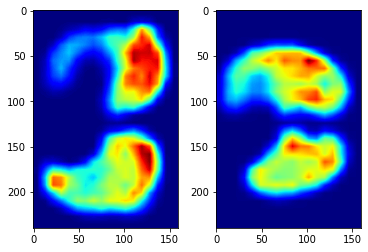

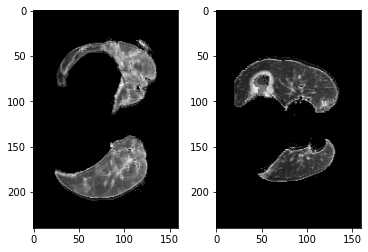


  1%|          | 1/103 [00:05<09:09,  5.39s/it]

LOSS MEDIO 0.7628002166748047
tensor([[0.1301, 0.8699],
        [0.9430, 0.0570],
        [0.7552, 0.2448],
        [0.0630, 0.9370]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013036369', '3013048570', '3013049257', '98062935']
tensor([1, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 1, Loss: 0.388554, Accuracy: 100.000000
Total accuracy: 75.0


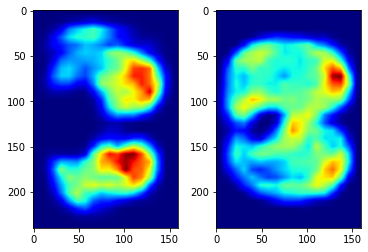

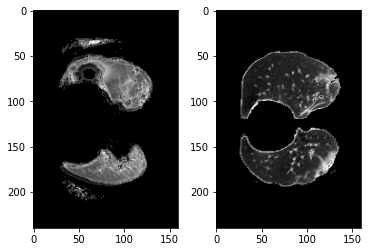


  2%|▏         | 2/103 [00:16<11:47,  7.01s/it]

LOSS MEDIO 0.5756771564483643
tensor([[0.2362, 0.7638],
        [0.6654, 0.3346],
        [0.8008, 0.1992],
        [0.2090, 0.7910]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2005022895', '2000009792', '3011916561', '99006571']
tensor([1, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 2, Loss: 0.471487, Accuracy: 100.000000
Total accuracy: 83.33333333333333


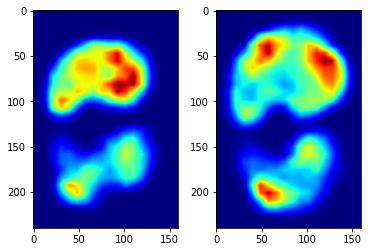

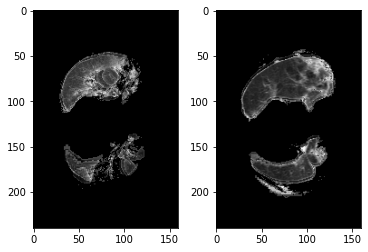


  3%|▎         | 3/103 [00:26<13:35,  8.15s/it]

LOSS MEDIO 0.5409469604492188
tensor([[0.8462, 0.1538],
        [0.1941, 0.8059],
        [0.1596, 0.8404],
        [0.7808, 0.2192]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3004115356', '3013096757', '97010481', '3013091456']
tensor([0, 0, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 3, Loss: 0.748148, Accuracy: 50.000000
Total accuracy: 75.0


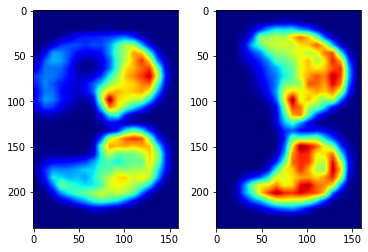

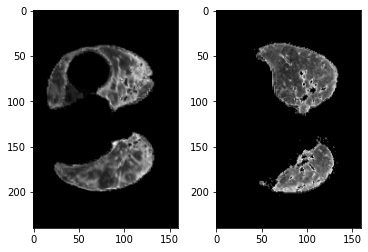


  4%|▍         | 4/103 [00:48<20:17, 12.30s/it]

LOSS MEDIO 0.5927473157644272
tensor([[0.1394, 0.8606],
        [0.7209, 0.2791],
        [0.0560, 0.9440],
        [0.9162, 0.0838]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2010026154', '3013058057', '99004462', '3013044156']
tensor([0, 0, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 4, Loss: 0.579886, Accuracy: 75.000000
Total accuracy: 75.0


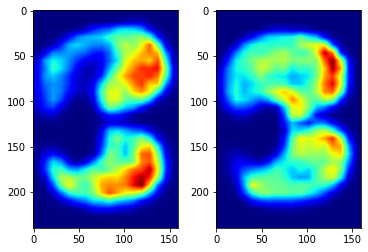

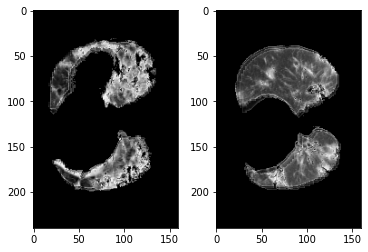


  5%|▍         | 5/103 [00:54<16:36, 10.17s/it]

LOSS MEDIO 0.5901750445365905
tensor([[0.1093, 0.8907],
        [0.7106, 0.2894],
        [0.8350, 0.1650],
        [0.1315, 0.8685]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['99009591', '3013049169', '3000354735', '3003474756']
tensor([0, 0, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 5, Loss: 0.801042, Accuracy: 50.000000
Total accuracy: 70.83333333333333


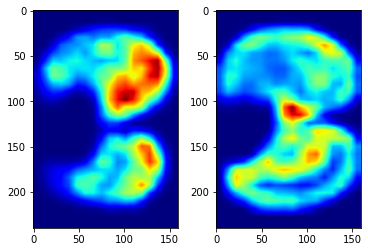

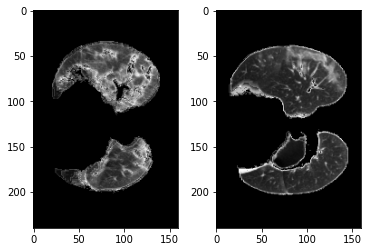


  6%|▌         | 6/103 [00:59<14:01,  8.68s/it]

LOSS MEDIO 0.6253195504347483
tensor([[0.2765, 0.7235],
        [0.4863, 0.5137],
        [0.8878, 0.1122],
        [0.2153, 0.7847]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['99012046', '2005022895', '2007016862', '3013050282']
tensor([1, 1, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 6, Loss: 0.642642, Accuracy: 75.000000
Total accuracy: 71.42857142857143


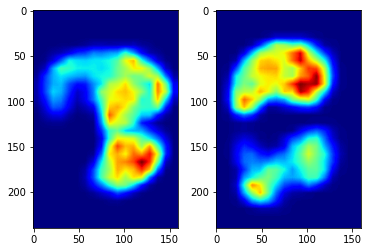

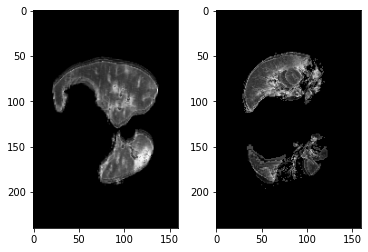


  7%|▋         | 7/103 [01:10<15:01,  9.39s/it]

LOSS MEDIO 0.6277942146573748
tensor([[0.2087, 0.7913],
        [0.1134, 0.8866],
        [0.9640, 0.0360],
        [0.3296, 0.6704]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3004116256', '3013050369', '3011916561', '3000368015']
tensor([1, 1, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 7, Loss: 0.508562, Accuracy: 75.000000
Total accuracy: 71.875


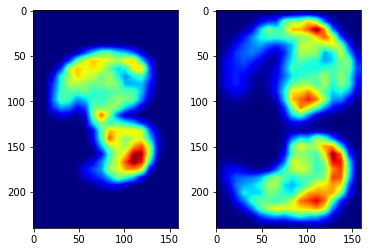

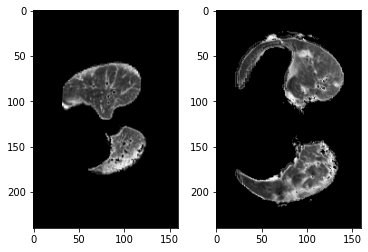


  8%|▊         | 8/103 [01:26<18:15, 11.53s/it]

LOSS MEDIO 0.6128901392221451
tensor([[0.5340, 0.4660],
        [0.0843, 0.9157],
        [0.3198, 0.6802],
        [0.9400, 0.0600]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2008024371', '98046931', '2006008854', '2001022566']
tensor([1, 1, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 8, Loss: 0.801432, Accuracy: 25.000000
Total accuracy: 66.66666666666667


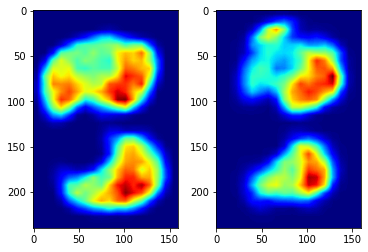

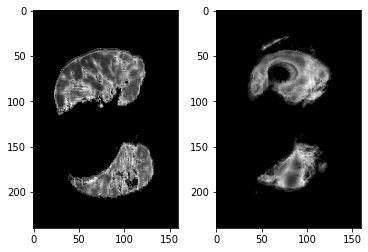


  9%|▊         | 9/103 [01:43<20:24, 13.02s/it]

LOSS MEDIO 0.6338392893473307
tensor([[0.7545, 0.2455],
        [0.0683, 0.9317],
        [0.5856, 0.4144],
        [0.7958, 0.2042]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2001042602', '2009023655', '3000259769', '2000031343']
tensor([0, 1, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 9, Loss: 0.616463, Accuracy: 75.000000
Total accuracy: 67.5


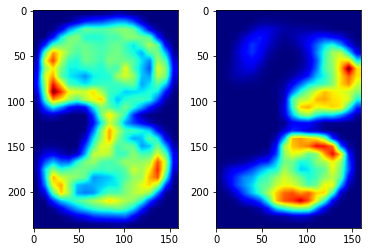

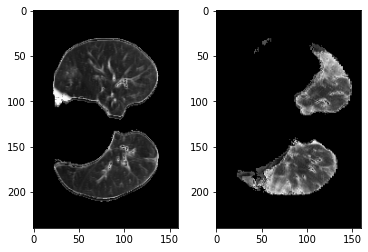


 10%|▉         | 10/103 [01:54<19:07, 12.34s/it]

LOSS MEDIO 0.6321016907691955
tensor([[0.0675, 0.9325],
        [0.6636, 0.3364],
        [0.2056, 0.7944],
        [0.9481, 0.0519]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013051158', '2000048966', '99028723', '2009015698']
tensor([1, 0, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 10, Loss: 0.566710, Accuracy: 75.000000
Total accuracy: 68.18181818181819


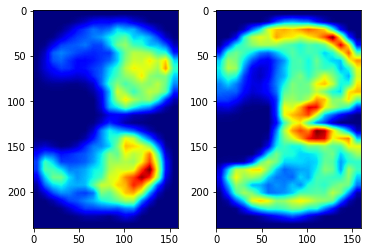

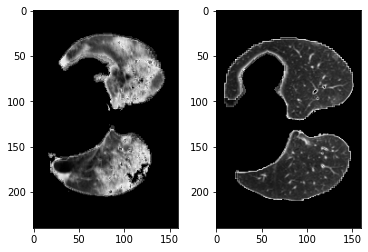


 11%|█         | 11/103 [01:59<15:43, 10.25s/it]

LOSS MEDIO 0.6261570020155474
tensor([[0.3424, 0.6576],
        [0.8775, 0.1225],
        [0.6033, 0.3967],
        [0.1562, 0.8438]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3001944456', '2002015207', '99038485', '2000009272']
tensor([1, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 11, Loss: 0.483914, Accuracy: 100.000000
Total accuracy: 70.83333333333333


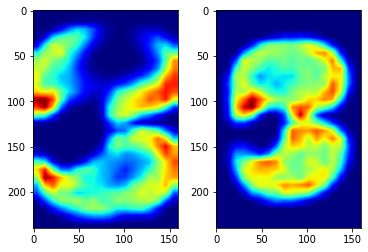

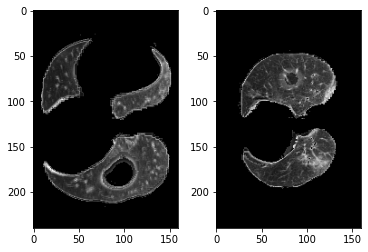


 12%|█▏        | 12/103 [02:04<13:19,  8.79s/it]

LOSS MEDIO 0.6143034100532532
tensor([[0.8796, 0.1204],
        [0.0991, 0.9009],
        [0.4367, 0.5633],
        [0.2285, 0.7715]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2009005327', '3003833457', '2006032421', '2008028148']
tensor([0, 1, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 12, Loss: 0.492735, Accuracy: 75.000000
Total accuracy: 71.15384615384616


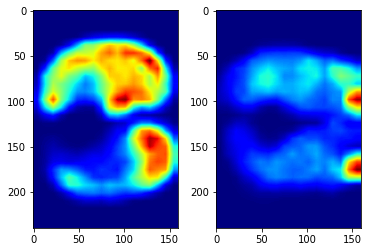

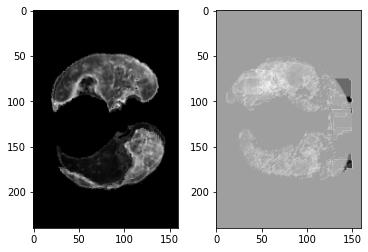


 13%|█▎        | 13/103 [02:10<11:43,  7.82s/it]

LOSS MEDIO 0.6049520121170924
tensor([[0.6070, 0.3930],
        [0.3668, 0.6332],
        [0.7839, 0.2161],
        [0.3379, 0.6621]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2005000615', '3013034566', '3013062458', '3013036369']
tensor([1, 1, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 13, Loss: 0.591939, Accuracy: 75.000000
Total accuracy: 71.42857142857143


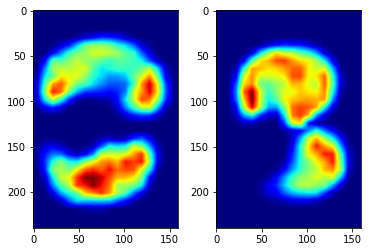

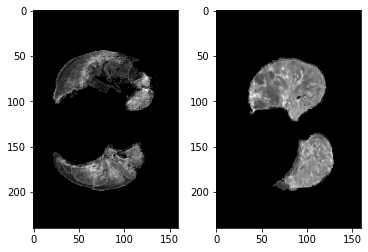


 14%|█▎        | 14/103 [02:16<10:35,  7.14s/it]

LOSS MEDIO 0.6040225092853818
tensor([[0.3663, 0.6337],
        [0.6642, 0.3358],
        [0.1073, 0.8927],
        [0.5692, 0.4308]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['98002419', '3013086856', '2011015370', '3013056557']
tensor([0, 0, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 14, Loss: 0.595050, Accuracy: 75.000000
Total accuracy: 71.66666666666667


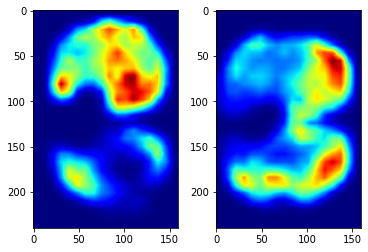

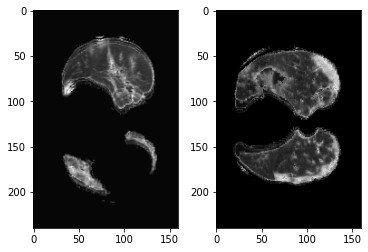


 15%|█▍        | 15/103 [02:27<12:10,  8.31s/it]

LOSS MEDIO 0.6034243404865265
tensor([[0.9145, 0.0855],
        [0.1799, 0.8201],
        [0.1208, 0.8792],
        [0.6554, 0.3446]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2005015270', '99028232', '3013050364', '2004025667']
tensor([0, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 15, Loss: 0.857258, Accuracy: 25.000000
Total accuracy: 68.75


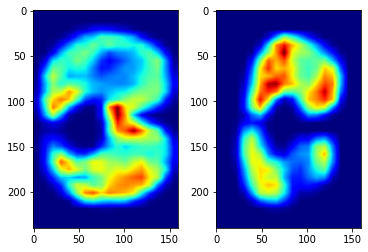

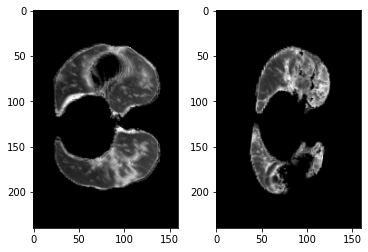


 16%|█▌        | 16/103 [02:32<10:55,  7.54s/it]

LOSS MEDIO 0.6192889343947172
tensor([[0.7817, 0.2183],
        [0.8708, 0.1292],
        [0.1231, 0.8769],
        [0.1219, 0.8781]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['99016972', '98017542', '3013096757', '2003008796']
tensor([0, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 16, Loss: 0.591144, Accuracy: 75.000000
Total accuracy: 69.11764705882354


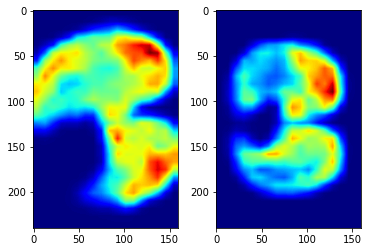

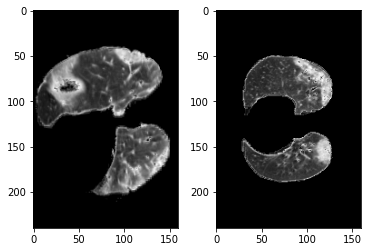


 17%|█▋        | 17/103 [02:54<16:57, 11.83s/it]

LOSS MEDIO 0.6176333515083089
tensor([[0.2435, 0.7565],
        [0.0680, 0.9320],
        [0.6598, 0.3402],
        [0.8265, 0.1735]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013052057', '3013046457', '98051841', '2000022002']
tensor([0, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 17, Loss: 0.953982, Accuracy: 25.000000
Total accuracy: 66.66666666666667


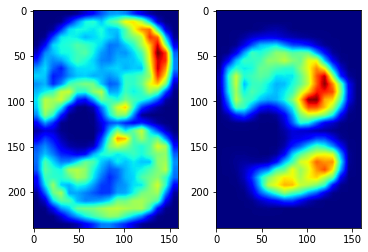

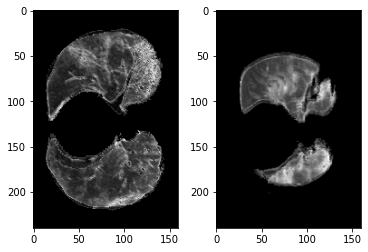


 17%|█▋        | 18/103 [03:05<16:19, 11.52s/it]

LOSS MEDIO 0.6363193872902129
tensor([[0.6744, 0.3256],
        [0.1450, 0.8550],
        [0.6410, 0.3590],
        [0.3408, 0.6592]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013052263', '3013050364', '2000053891', '3013050278']
tensor([0, 0, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 18, Loss: 0.838176, Accuracy: 25.000000
Total accuracy: 64.47368421052632


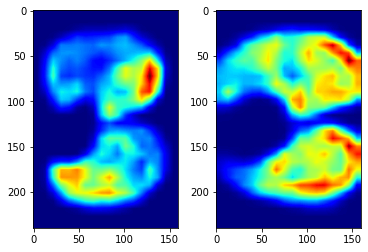

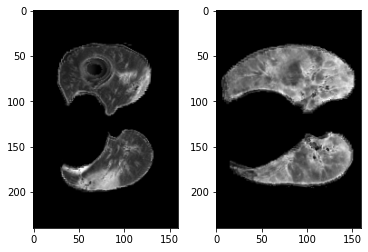


 18%|█▊        | 19/103 [03:27<20:30, 14.64s/it]

LOSS MEDIO 0.6469433982121316
tensor([[0.1957, 0.8043],
        [0.0980, 0.9020],
        [0.8856, 0.1144],
        [0.6278, 0.3722]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013044256', '2000018228', '2001041602', '2011004419']
tensor([1, 1, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 19, Loss: 0.439472, Accuracy: 100.000000
Total accuracy: 66.25


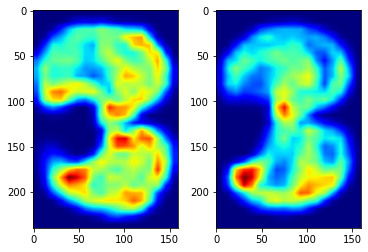

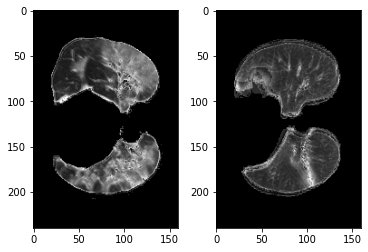


 19%|█▉        | 20/103 [03:32<16:21, 11.82s/it]

LOSS MEDIO 0.6365698352456093
tensor([[0.0569, 0.9431],
        [0.8244, 0.1756],
        [0.8011, 0.1989],
        [0.4354, 0.5646]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3000290711', '3000332556', '3000209058', '2001035431']
tensor([1, 0, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 20, Loss: 0.641095, Accuracy: 50.000000
Total accuracy: 65.47619047619048


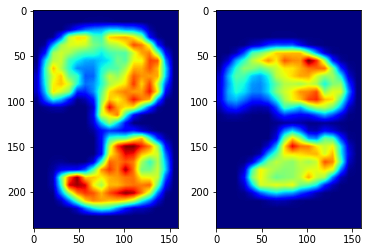

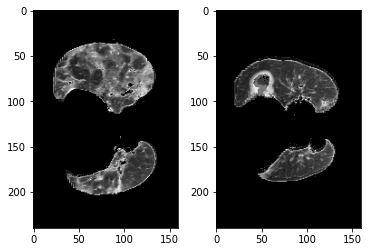


 20%|██        | 21/103 [03:38<13:31,  9.90s/it]

LOSS MEDIO 0.636785321292423
tensor([[0.0974, 0.9026],
        [0.5554, 0.4446],
        [0.7953, 0.2047],
        [0.4111, 0.5889]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2011015370', '3013046461', '3006957856', '3013049258']
tensor([1, 0, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 21, Loss: 0.558912, Accuracy: 75.000000
Total accuracy: 65.9090909090909


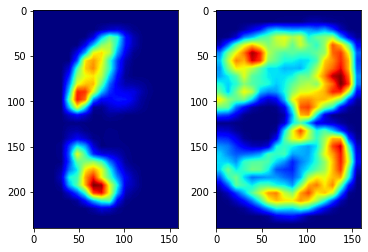

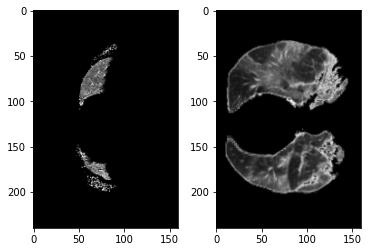


 21%|██▏       | 22/103 [03:59<18:03, 13.38s/it]

LOSS MEDIO 0.6332456130873073
tensor([[0.1124, 0.8876],
        [0.9429, 0.0571],
        [0.7454, 0.2546],
        [0.1319, 0.8681]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2006004951', '2008023271', '2000018228', '2000007568']
tensor([1, 0, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 22, Loss: 0.520939, Accuracy: 75.000000
Total accuracy: 66.30434782608695


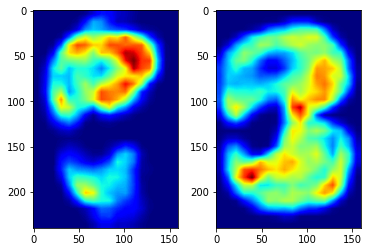

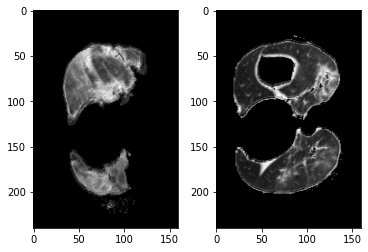


 22%|██▏       | 23/103 [04:15<18:51, 14.14s/it]

LOSS MEDIO 0.6283627009910085
tensor([[0.1567, 0.8433],
        [0.9570, 0.0430],
        [0.2707, 0.7293],
        [0.4478, 0.5522]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2001038210', '3013058056', '99044390', '2007021444']
tensor([1, 0, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 23, Loss: 0.469230, Accuracy: 100.000000
Total accuracy: 67.70833333333333


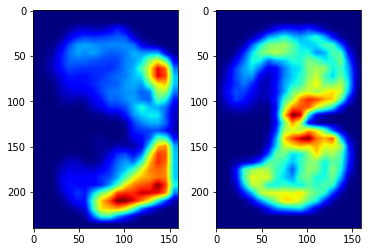

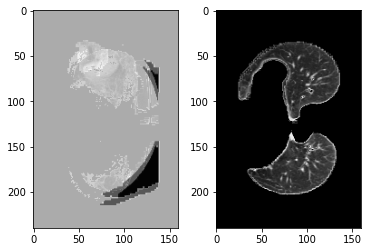


 23%|██▎       | 24/103 [04:20<15:09, 11.51s/it]

LOSS MEDIO 0.6217321741084257
tensor([[0.5458, 0.4542],
        [0.2334, 0.7666],
        [0.8372, 0.1628],
        [0.1713, 0.8287]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3000209058', '2000053891', '98051983', '3013043157']
tensor([1, 1, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 24, Loss: 0.672094, Accuracy: 50.000000
Total accuracy: 67.0


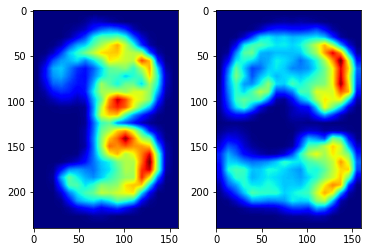

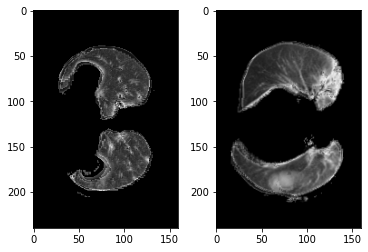


 24%|██▍       | 25/103 [04:31<14:43, 11.33s/it]

LOSS MEDIO 0.623746646642685
tensor([[0.4999, 0.5001],
        [0.7849, 0.2151],
        [0.8819, 0.1181],
        [0.1433, 0.8567]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013082956', '99034708', '97020502', '3013040861']
tensor([0, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 25, Loss: 0.480706, Accuracy: 75.000000
Total accuracy: 67.3076923076923


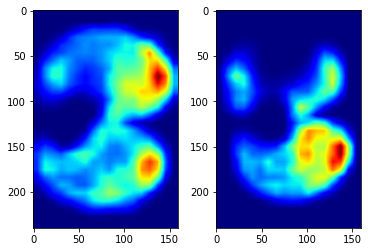

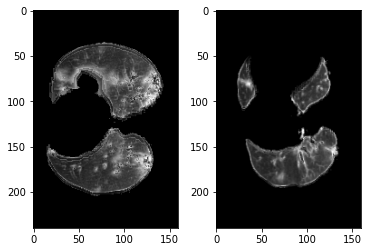


 25%|██▌       | 26/103 [04:42<14:27, 11.27s/it]

LOSS MEDIO 0.6182450709434656
tensor([[0.8801, 0.1199],
        [0.2369, 0.7631],
        [0.1514, 0.8486],
        [0.5808, 0.4192]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2007026288', '3013055658', '98062935', '3013052456']
tensor([0, 1, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 26, Loss: 0.466907, Accuracy: 100.000000
Total accuracy: 68.51851851851852


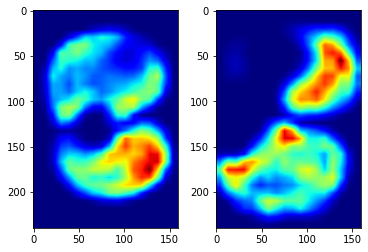

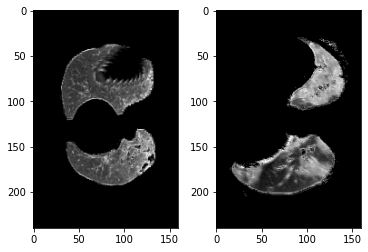


 26%|██▌       | 27/103 [04:54<14:15, 11.26s/it]

LOSS MEDIO 0.6126399514851747
tensor([[0.6710, 0.3290],
        [0.8307, 0.1693],
        [0.6024, 0.3976],
        [0.0373, 0.9627]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3011614956', '3013026557', '2001022566', '97017096']
tensor([0, 0, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 27, Loss: 0.521866, Accuracy: 75.000000
Total accuracy: 68.75


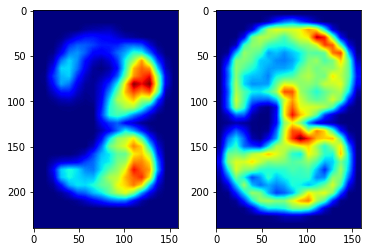

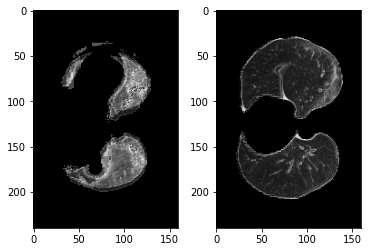


 27%|██▋       | 28/103 [04:59<11:47,  9.43s/it]

LOSS MEDIO 0.6093980212296758
tensor([[0.4663, 0.5337],
        [0.5875, 0.4125],
        [0.1109, 0.8891],
        [0.4884, 0.5116]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013055556', '3011916561', '2004022806', '3013036659']
tensor([0, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 28, Loss: 0.793647, Accuracy: 50.000000
Total accuracy: 68.10344827586206


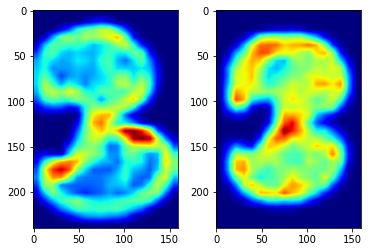

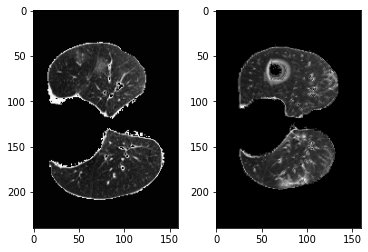


 28%|██▊       | 29/103 [05:04<10:11,  8.27s/it]

LOSS MEDIO 0.6157514339890974
tensor([[0.0672, 0.9328],
        [0.8651, 0.1349],
        [0.9305, 0.0695],
        [0.2098, 0.7902]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['98046931', '2011011692', '3004115356', '2000009272']
tensor([1, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 29, Loss: 0.385395, Accuracy: 100.000000
Total accuracy: 69.16666666666667


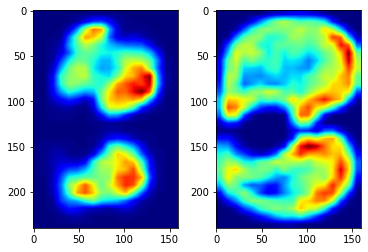

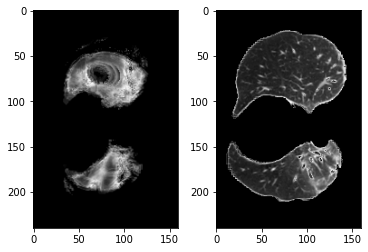


 29%|██▉       | 30/103 [05:15<10:57,  9.01s/it]

LOSS MEDIO 0.608072887857755
tensor([[0.6916, 0.3084],
        [0.8148, 0.1852],
        [0.0352, 0.9648],
        [0.1757, 0.8243]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['98062297', '3013026557', '97017096', '3013068956']
tensor([0, 0, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 30, Loss: 0.425027, Accuracy: 100.000000
Total accuracy: 70.16129032258064


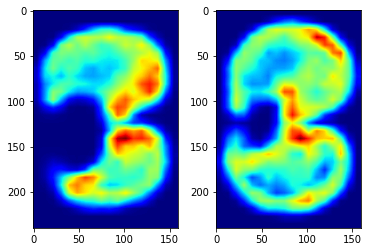

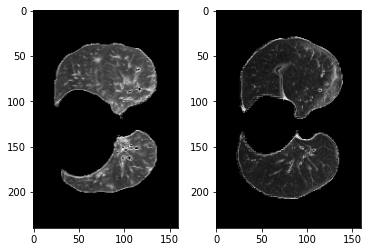


 30%|███       | 31/103 [05:20<09:29,  7.91s/it]

LOSS MEDIO 0.6021681860569985
tensor([[0.7527, 0.2473],
        [0.8021, 0.1979],
        [0.1607, 0.8393],
        [0.1542, 0.8458]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2000031343', '2006014381', '3013049156', '3013049165']
tensor([1, 0, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 31, Loss: 0.899977, Accuracy: 25.000000
Total accuracy: 68.75


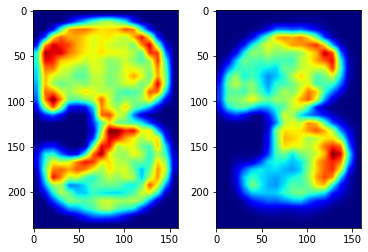

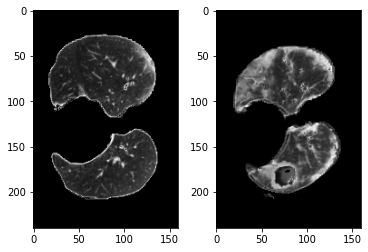


 31%|███       | 32/103 [05:31<10:23,  8.79s/it]

LOSS MEDIO 0.611474703066051
tensor([[0.8062, 0.1938],
        [0.8403, 0.1597],
        [0.3416, 0.6584],
        [0.0314, 0.9686]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013082956', '3013058056', '3009904256', '97017096']
tensor([0, 0, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 32, Loss: 0.430154, Accuracy: 100.000000
Total accuracy: 69.6969696969697


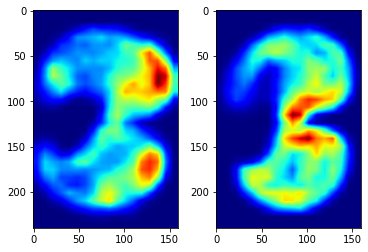

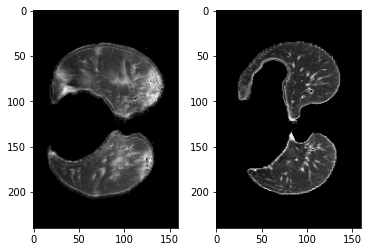


 32%|███▏      | 33/103 [05:47<12:46, 10.96s/it]

LOSS MEDIO 0.6059801289529512
tensor([[0.0896, 0.9104],
        [0.4138, 0.5862],
        [0.3925, 0.6075],
        [0.8512, 0.1488]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['99018871', '2003032715', '3013050362', '3000281090']
tensor([1, 1, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 33, Loss: 0.667883, Accuracy: 75.000000
Total accuracy: 69.8529411764706


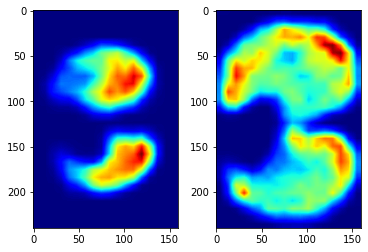

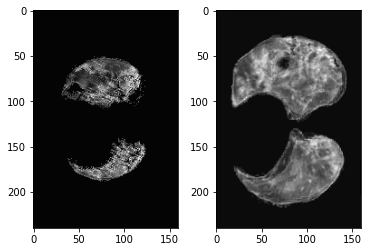


 33%|███▎      | 34/103 [05:58<12:30, 10.88s/it]

LOSS MEDIO 0.6078008062699262
tensor([[0.7458, 0.2542],
        [0.5818, 0.4182],
        [0.3553, 0.6447],
        [0.4606, 0.5394]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3002739856', '2011011692', '99010680', '2000053891']
tensor([1, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 34, Loss: 0.771601, Accuracy: 50.000000
Total accuracy: 69.28571428571429


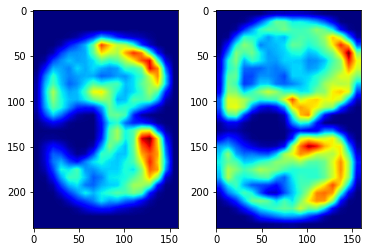

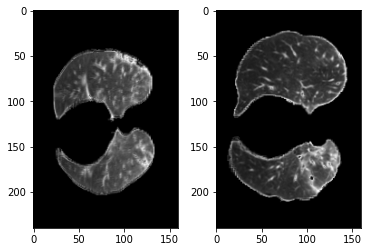


 34%|███▍      | 35/103 [06:20<15:57, 14.08s/it]

LOSS MEDIO 0.6124808175223214
tensor([[0.3037, 0.6963],
        [0.8272, 0.1728],
        [0.1816, 0.8184],
        [0.5431, 0.4569]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2003032715', '2000028355', '3013050360', '3013050166']
tensor([1, 0, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 35, Loss: 0.661722, Accuracy: 75.000000
Total accuracy: 69.44444444444444


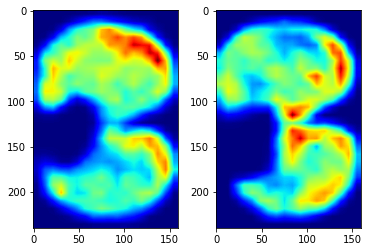

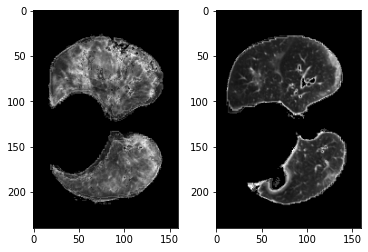


 35%|███▍      | 36/103 [06:25<12:47, 11.45s/it]

LOSS MEDIO 0.6138486150238249
tensor([[0.0993, 0.9007],
        [0.8405, 0.1595],
        [0.4054, 0.5946],
        [0.5121, 0.4879]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013030057', '98043872', '3001450856', '98044369']
tensor([1, 0, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 36, Loss: 0.522134, Accuracy: 75.000000
Total accuracy: 69.5945945945946


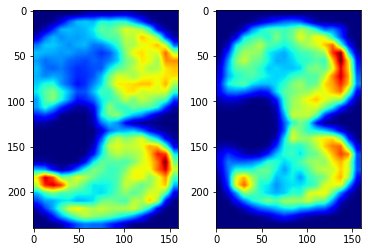

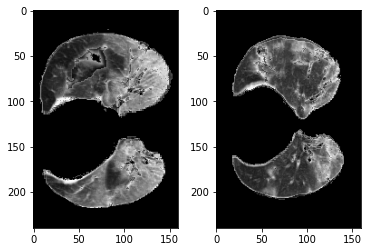


 36%|███▌      | 37/103 [06:35<12:17, 11.17s/it]

LOSS MEDIO 0.6113698498622792
tensor([[0.6833, 0.3167],
        [0.4991, 0.5009],
        [0.5056, 0.4944],
        [0.3134, 0.6866]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2010026154', '3013040861', '3013050364', '3013054357']
tensor([0, 1, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 37, Loss: 0.700865, Accuracy: 75.000000
Total accuracy: 69.73684210526316


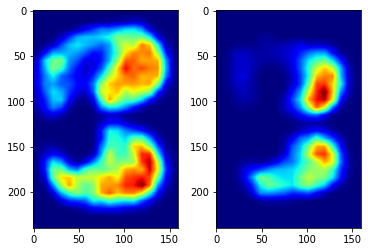

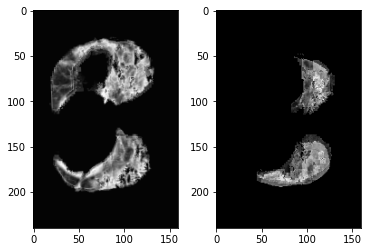


 37%|███▋      | 38/103 [06:51<13:38, 12.59s/it]

LOSS MEDIO 0.6137249956005498
tensor([[0.0621, 0.9379],
        [0.6215, 0.3785],
        [0.5876, 0.4124],
        [0.7895, 0.2105]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2001038210', '3000158905', '2007026288', '3000259769']
tensor([1, 0, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 38, Loss: 0.495408, Accuracy: 100.000000
Total accuracy: 70.51282051282051


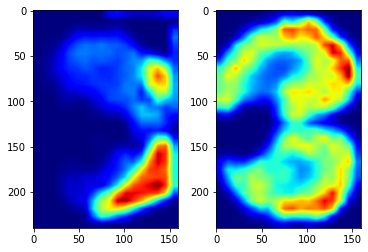

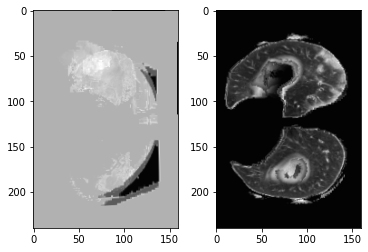


 38%|███▊      | 39/103 [07:08<14:36, 13.69s/it]

LOSS MEDIO 0.6106912386723053
tensor([[0.0548, 0.9452],
        [0.4544, 0.5456],
        [0.8741, 0.1259],
        [0.7789, 0.2211]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013068956', '2009005327', '2000006283', '2000022002']
tensor([1, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 39, Loss: 0.620404, Accuracy: 50.000000
Total accuracy: 70.0


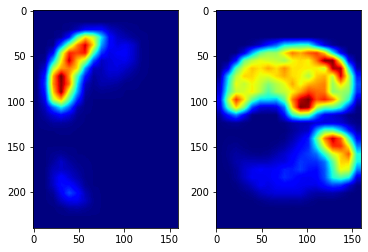

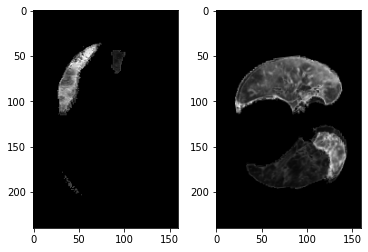


 39%|███▉      | 40/103 [07:13<11:47, 11.23s/it]

LOSS MEDIO 0.6109340518712998
tensor([[0.9107, 0.0893],
        [0.2742, 0.7258],
        [0.1467, 0.8533],
        [0.5532, 0.4468]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['98000894', '98055323', '99006571', '2000028355']
tensor([0, 1, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 40, Loss: 0.474878, Accuracy: 100.000000
Total accuracy: 70.73170731707317


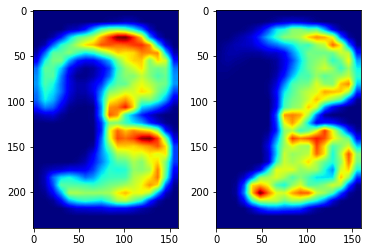

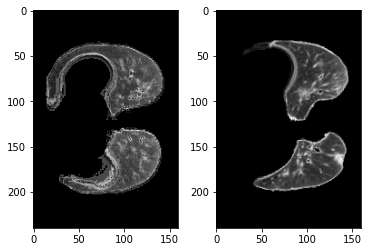


 40%|███▉      | 41/103 [07:34<14:44, 14.26s/it]

LOSS MEDIO 0.6076156140827551
tensor([[0.8511, 0.1489],
        [0.1047, 0.8953],
        [0.1994, 0.8006],
        [0.7718, 0.2282]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['97002989', '3013040669', '99014670', '3009171558']
tensor([1, 1, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 41, Loss: 0.593388, Accuracy: 75.000000
Total accuracy: 70.83333333333333


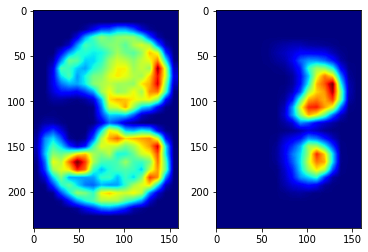

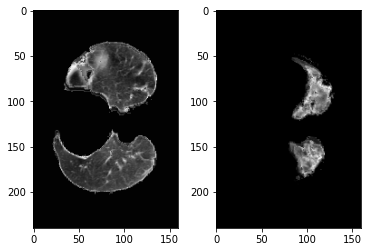


 41%|████      | 42/103 [07:45<13:29, 13.27s/it]

LOSS MEDIO 0.6072768675429481
tensor([[0.8485, 0.1515],
        [0.5148, 0.4852],
        [0.1469, 0.8531],
        [0.4704, 0.5296]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013049169', '2009005327', '2006008854', '3013046564']
tensor([0, 0, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 42, Loss: 0.728298, Accuracy: 50.000000
Total accuracy: 70.34883720930233


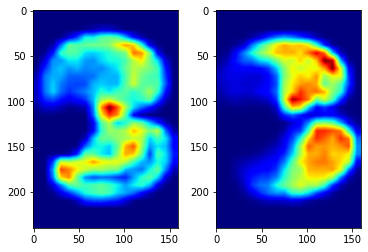

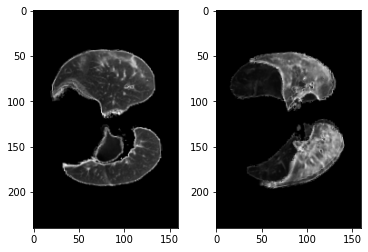


 42%|████▏     | 43/103 [07:56<12:34, 12.58s/it]

LOSS MEDIO 0.6100913154524427
tensor([[0.5414, 0.4586],
        [0.0970, 0.9030],
        [0.3139, 0.6861],
        [0.9569, 0.0431]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3005859856', '3013051158', '2003022562', '2011034002']
tensor([1, 1, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 43, Loss: 0.584574, Accuracy: 50.000000
Total accuracy: 69.88636363636364


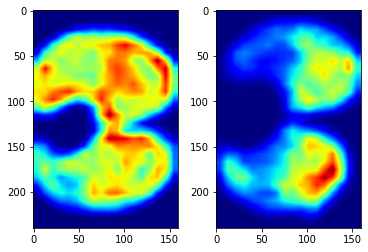

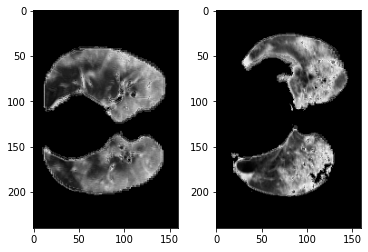


 43%|████▎     | 44/103 [08:01<10:10, 10.35s/it]

LOSS MEDIO 0.6095113774592226
tensor([[0.7069, 0.2931],
        [0.1021, 0.8979],
        [0.5225, 0.4775],
        [0.7570, 0.2430]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013046656', '99012046', '2002038834', '3006957856']
tensor([0, 1, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 44, Loss: 0.504907, Accuracy: 100.000000
Total accuracy: 70.55555555555556


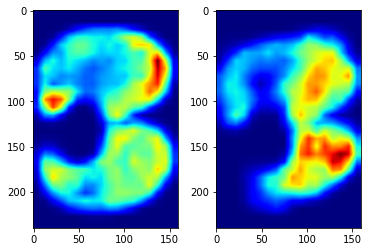

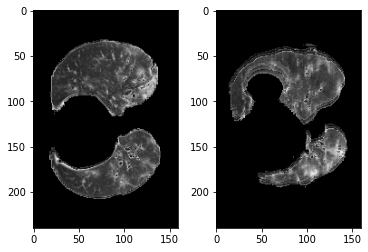


 44%|████▎     | 45/103 [08:07<08:31,  8.82s/it]

LOSS MEDIO 0.6071868466006385
tensor([[0.1857, 0.8143],
        [0.8291, 0.1709],
        [0.6229, 0.3771],
        [0.2769, 0.7231]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013052258', '2002013985', '2000009792', '3013034566']
tensor([1, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 45, Loss: 0.479294, Accuracy: 100.000000
Total accuracy: 71.19565217391305


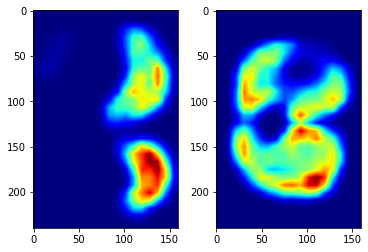

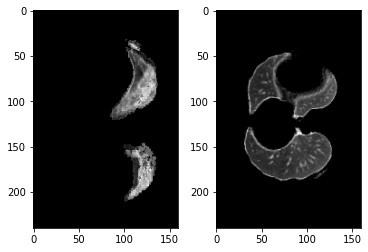


 45%|████▍     | 46/103 [08:17<08:56,  9.41s/it]

LOSS MEDIO 0.6044065673714099
tensor([[0.6418, 0.3582],
        [0.7560, 0.2440],
        [0.8296, 0.1704],
        [0.0443, 0.9557]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2000040295', '2005023230', '2001031231', '3013050756']
tensor([0, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 46, Loss: 0.446424, Accuracy: 100.000000
Total accuracy: 71.80851063829788


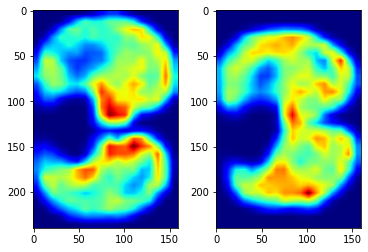

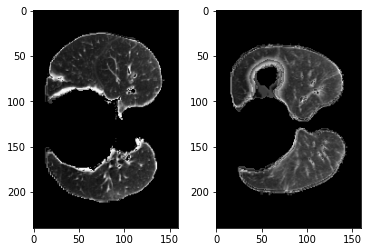


 46%|████▌     | 47/103 [08:28<09:06,  9.76s/it]

LOSS MEDIO 0.6010452363085239
tensor([[0.3417, 0.6583],
        [0.8079, 0.1921],
        [0.1261, 0.8739],
        [0.5689, 0.4311]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013030057', '2006008854', '3013050362', '2004032816']
tensor([1, 0, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 47, Loss: 0.532835, Accuracy: 75.000000
Total accuracy: 71.875


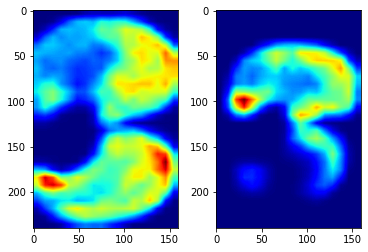

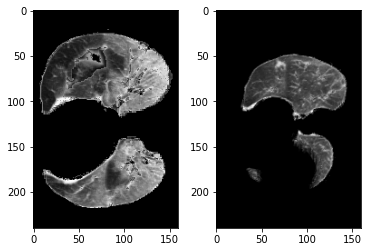


 47%|████▋     | 48/103 [08:39<09:12, 10.04s/it]

LOSS MEDIO 0.5996241923421621
tensor([[0.7393, 0.2607],
        [0.0735, 0.9265],
        [0.3372, 0.6628],
        [0.8664, 0.1336]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2003000649', '2011015370', '2005033922', '3008825560']
tensor([0, 1, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 48, Loss: 0.524693, Accuracy: 75.000000
Total accuracy: 71.93877551020408


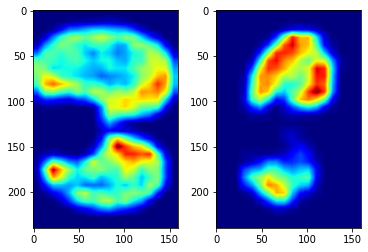

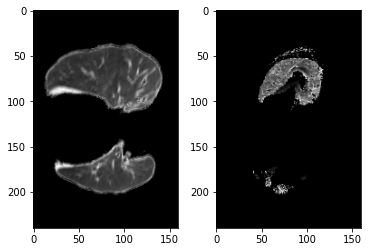


 48%|████▊     | 49/103 [08:55<10:38, 11.83s/it]

LOSS MEDIO 0.5980949821520825
tensor([[0.2482, 0.7518],
        [0.6190, 0.3810],
        [0.3740, 0.6260],
        [0.8398, 0.1602]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2003032715', '2003014639', '2008024371', '3011614956']
tensor([1, 1, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 49, Loss: 0.569259, Accuracy: 75.000000
Total accuracy: 72.0


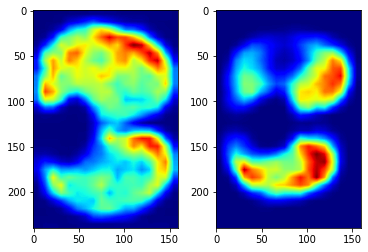

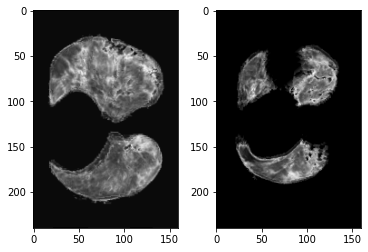


 49%|████▊     | 50/103 [09:06<10:11, 11.53s/it]

LOSS MEDIO 0.5975182527303695
tensor([[0.4602, 0.5398],
        [0.9357, 0.0643],
        [0.3225, 0.6775],
        [0.1240, 0.8760]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['99020282', '99034614', '99044390', '3000359067']
tensor([1, 1, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 50, Loss: 0.698169, Accuracy: 75.000000
Total accuracy: 72.05882352941177


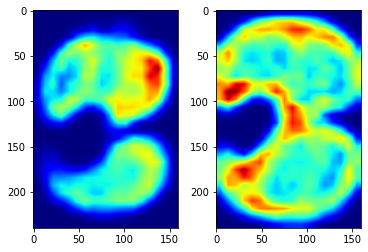

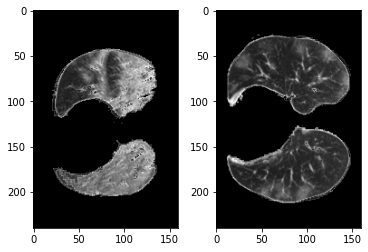


 50%|████▉     | 51/103 [09:16<09:45, 11.25s/it]

LOSS MEDIO 0.5994918001633064
tensor([[0.8126, 0.1874],
        [0.4790, 0.5210],
        [0.4194, 0.5806],
        [0.2249, 0.7751]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3006046158', '98051841', '3013036068', '2000027225']
tensor([0, 0, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 51, Loss: 0.731417, Accuracy: 25.000000
Total accuracy: 71.15384615384616


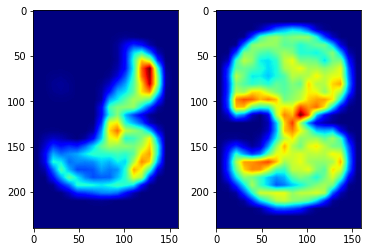

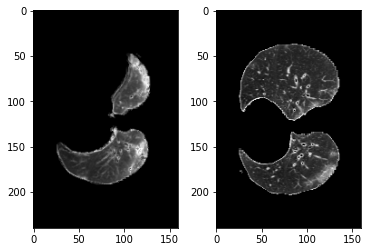


 50%|█████     | 52/103 [09:22<08:05,  9.51s/it]

LOSS MEDIO 0.6020288140727923
tensor([[0.5827, 0.4173],
        [0.8130, 0.1870],
        [0.3671, 0.6329],
        [0.2773, 0.7227]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013025979', '2003016260', '3005859856', '2001037314']
tensor([0, 0, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 52, Loss: 0.637924, Accuracy: 75.000000
Total accuracy: 71.22641509433963


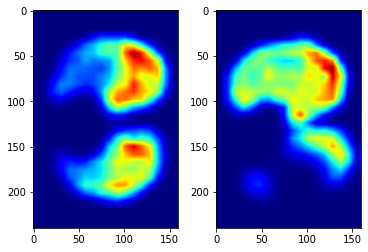

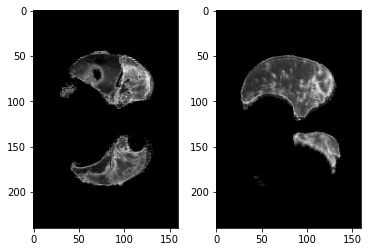


 51%|█████▏    | 53/103 [09:27<06:52,  8.25s/it]

LOSS MEDIO 0.6027060842738962
tensor([[0.8599, 0.1401],
        [0.8971, 0.1029],
        [0.1838, 0.8162],
        [0.0623, 0.9377]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2003029342', '2003029342', '3000291202', '2000007568']
tensor([0, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 53, Loss: 0.544109, Accuracy: 75.000000
Total accuracy: 71.29629629629629


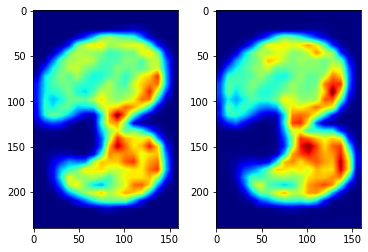

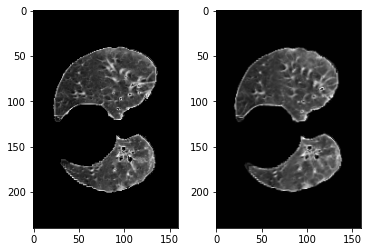


 52%|█████▏    | 54/103 [09:48<09:55, 12.16s/it]

LOSS MEDIO 0.6016209451136766
tensor([[0.6789, 0.3211],
        [0.2043, 0.7957],
        [0.0974, 0.9026],
        [0.9096, 0.0904]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2001049934', '3012459856', '3000359067', '3013049169']
tensor([0, 1, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 54, Loss: 0.426350, Accuracy: 100.000000
Total accuracy: 71.81818181818181


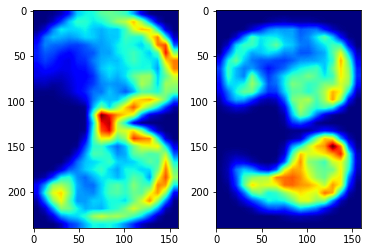

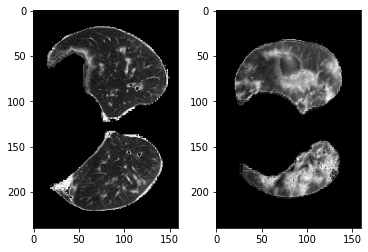


 53%|█████▎    | 55/103 [09:54<08:05, 10.11s/it]

LOSS MEDIO 0.598434209281748
tensor([[0.2158, 0.7842],
        [0.7963, 0.2037],
        [0.2220, 0.7780],
        [0.8600, 0.1400]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['98019932', '3013046459', '3000170175', '2006020867']
tensor([1, 0, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 55, Loss: 0.614710, Accuracy: 75.000000
Total accuracy: 71.875


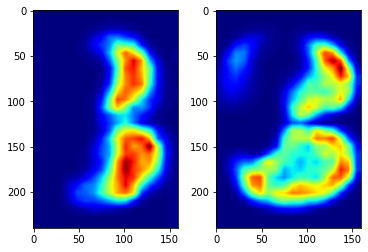

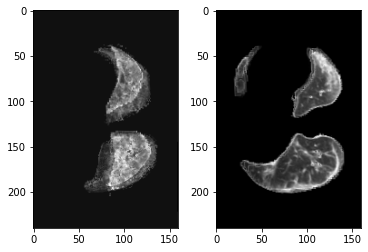


 54%|█████▍    | 56/103 [10:09<09:15, 11.82s/it]

LOSS MEDIO 0.5987248532474041
tensor([[0.3987, 0.6013],
        [0.5781, 0.4219],
        [0.3332, 0.6668],
        [0.4430, 0.5570]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2001036577', '3008304758', '2008002928', '3000319667']
tensor([0, 1, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 56, Loss: 0.687958, Accuracy: 50.000000
Total accuracy: 71.49122807017544


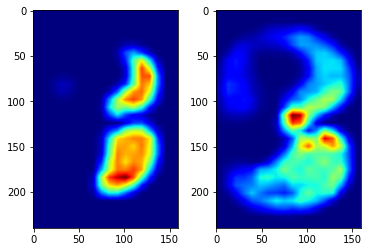

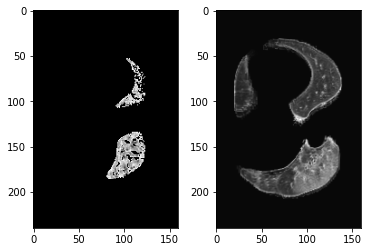


 55%|█████▌    | 57/103 [10:25<10:02, 13.09s/it]

LOSS MEDIO 0.6002903418582782
tensor([[0.1323, 0.8677],
        [0.0756, 0.9244],
        [0.9325, 0.0675],
        [0.6205, 0.3795]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3000319667', '2006014469', '2011038182', '3004088456']
tensor([1, 1, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 57, Loss: 0.419764, Accuracy: 100.000000
Total accuracy: 71.98275862068965


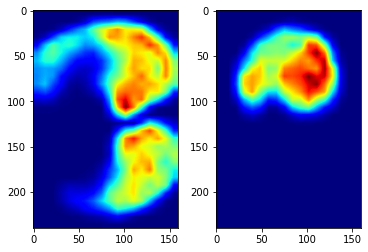

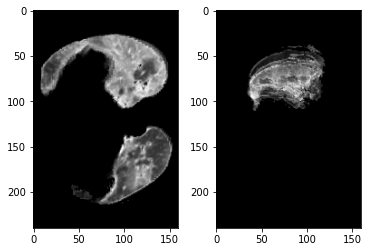


 56%|█████▋    | 58/103 [10:42<10:31, 14.02s/it]

LOSS MEDIO 0.5971778122515514
tensor([[0.8996, 0.1004],
        [0.5497, 0.4503],
        [0.6242, 0.3758],
        [0.1770, 0.8230]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2002043100', '97017291', '3000342810', '3013096757']
tensor([0, 1, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 58, Loss: 0.689891, Accuracy: 50.000000
Total accuracy: 71.61016949152543


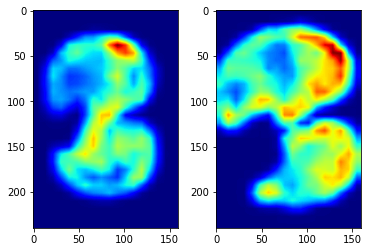

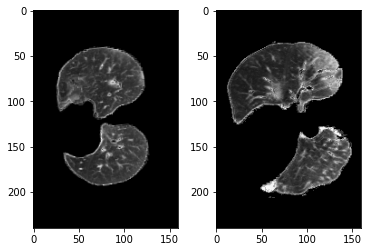


 57%|█████▋    | 59/103 [10:47<08:21, 11.41s/it]

LOSS MEDIO 0.5987492218866186
tensor([[0.0795, 0.9205],
        [0.9585, 0.0415],
        [0.4727, 0.5273],
        [0.1799, 0.8201]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3000359067', '2007001412', '99041056', '3013025979']
tensor([1, 0, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 59, Loss: 0.619825, Accuracy: 50.000000
Total accuracy: 71.25


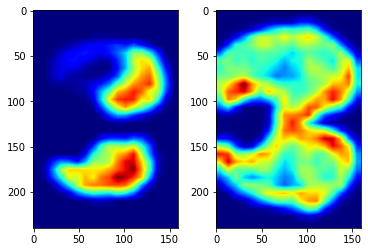

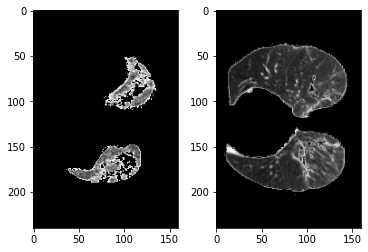


 58%|█████▊    | 60/103 [10:57<07:57, 11.11s/it]

LOSS MEDIO 0.5991004789868991
tensor([[0.9121, 0.0879],
        [0.2670, 0.7330],
        [0.5472, 0.4528],
        [0.1216, 0.8784]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2011012765', '3013051159', '3012400256', '3013050756']
tensor([0, 1, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 60, Loss: 0.494221, Accuracy: 75.000000
Total accuracy: 71.31147540983606


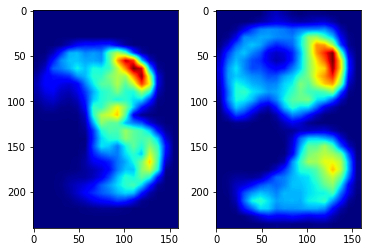

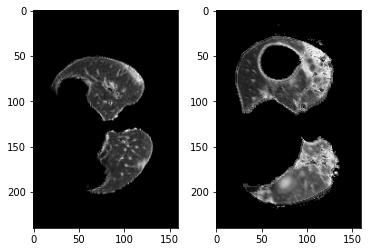


 59%|█████▉    | 61/103 [11:08<07:42, 11.00s/it]

LOSS MEDIO 0.5973811511133538
tensor([[0.7613, 0.2387],
        [0.8695, 0.1305],
        [0.2319, 0.7681],
        [0.0924, 0.9076]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3000259769', '99015639', '3000337851', '2000018228']
tensor([0, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 61, Loss: 0.554809, Accuracy: 75.000000
Total accuracy: 71.37096774193549


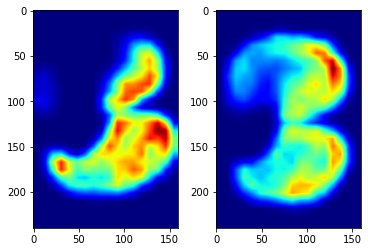

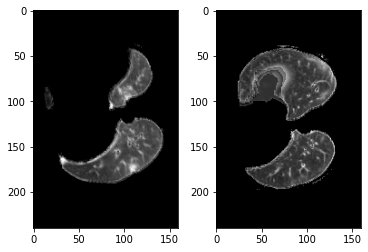


 60%|██████    | 62/103 [11:19<07:27, 10.92s/it]

LOSS MEDIO 0.5966944973314962
tensor([[0.4880, 0.5120],
        [0.6219, 0.3781],
        [0.1155, 0.8845],
        [0.8368, 0.1632]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3000281090', '97013538', '3013050756', '2000022002']
tensor([1, 0, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 62, Loss: 0.681593, Accuracy: 75.000000
Total accuracy: 71.42857142857143


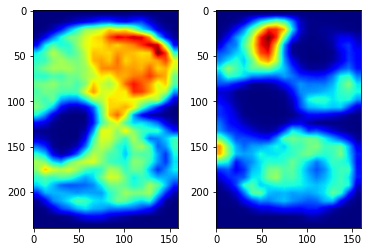

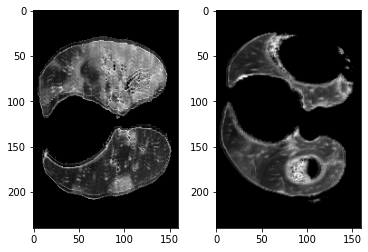


 61%|██████    | 63/103 [11:35<08:18, 12.47s/it]

LOSS MEDIO 0.5980420897877405
tensor([[0.1279, 0.8721],
        [0.7645, 0.2355],
        [0.2931, 0.7069],
        [0.7442, 0.2558]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3012113157', '99041056', '99004462', '2011011692']
tensor([1, 0, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 63, Loss: 0.459477, Accuracy: 100.000000
Total accuracy: 71.875


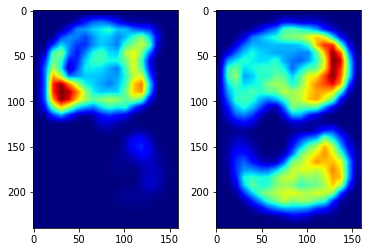

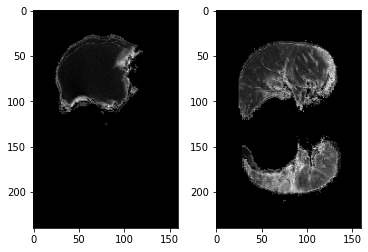


 62%|██████▏   | 64/103 [11:45<07:43, 11.88s/it]

LOSS MEDIO 0.5958770141005516
tensor([[0.3622, 0.6378],
        [0.2124, 0.7876],
        [0.8043, 0.1957],
        [0.5275, 0.4725]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2004021722', '2001009721', '3013052956', '3008304758']
tensor([1, 1, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 64, Loss: 0.541676, Accuracy: 75.000000
Total accuracy: 71.92307692307692


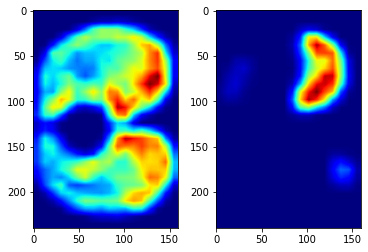

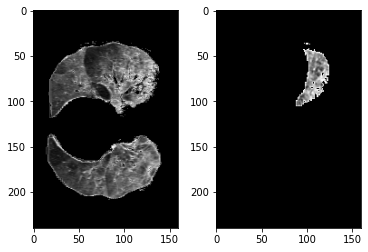


 63%|██████▎   | 65/103 [11:51<06:14,  9.86s/it]

LOSS MEDIO 0.5950431521122272
tensor([[0.5719, 0.4281],
        [0.9232, 0.0768],
        [0.0613, 0.9387],
        [0.5146, 0.4854]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2010011404', '3013053261', '98051375', '98044485']
tensor([0, 0, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 65, Loss: 0.501794, Accuracy: 100.000000
Total accuracy: 72.34848484848484


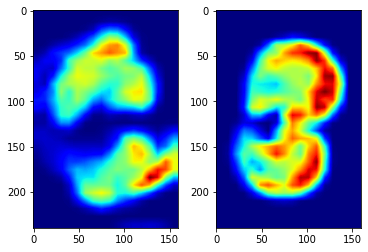

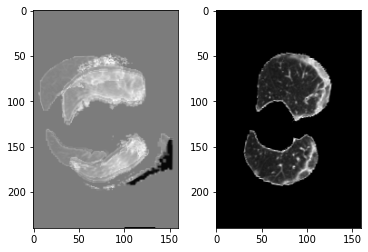


 64%|██████▍   | 66/103 [12:07<07:14, 11.73s/it]

LOSS MEDIO 0.5936302921988748
tensor([[0.8459, 0.1541],
        [0.7951, 0.2049],
        [0.1443, 0.8557],
        [0.2078, 0.7922]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3008236259', '2006020867', '3013054357', '2001009721']
tensor([0, 1, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 66, Loss: 0.747745, Accuracy: 50.000000
Total accuracy: 72.01492537313433


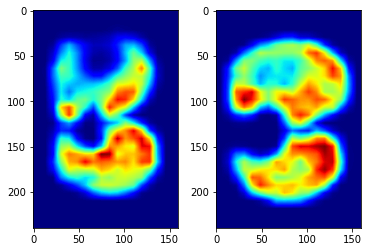

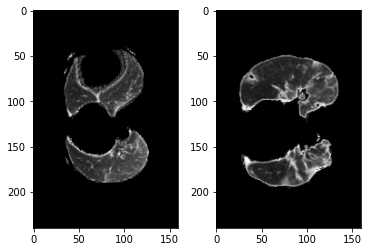


 65%|██████▌   | 67/103 [12:17<06:52, 11.45s/it]

LOSS MEDIO 0.5959305069339809
tensor([[0.0847, 0.9153],
        [0.1483, 0.8517],
        [0.9313, 0.0687],
        [0.7388, 0.2612]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2009000100', '2001036577', '99015639', '3013043956']
tensor([0, 0, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 67, Loss: 0.783113, Accuracy: 50.000000
Total accuracy: 71.69117647058823


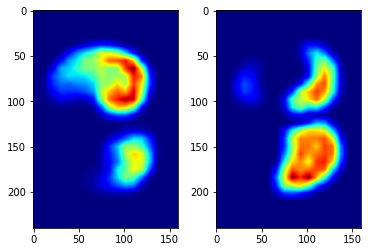

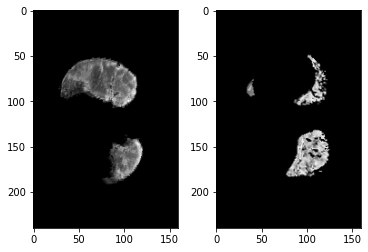


 66%|██████▌   | 68/103 [12:28<06:32, 11.21s/it]

LOSS MEDIO 0.5986831906963798
tensor([[0.7089, 0.2911],
        [0.3312, 0.6688],
        [0.8813, 0.1187],
        [0.0409, 0.9591]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2000053891', '2002047338', '99016469', '2007005091']
tensor([1, 1, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 68, Loss: 0.774786, Accuracy: 50.000000
Total accuracy: 71.3768115942029


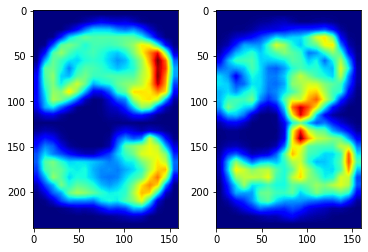

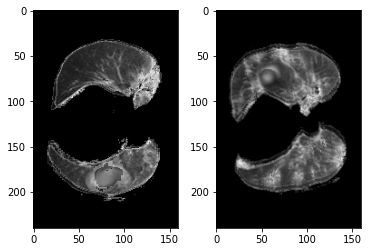


 67%|██████▋   | 69/103 [12:39<06:15, 11.03s/it]

LOSS MEDIO 0.6012354018031687
tensor([[0.6638, 0.3362],
        [0.1665, 0.8335],
        [0.3616, 0.6384],
        [0.8404, 0.1596]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3000150314', '2003014639', '3013040669', '2002027670']
tensor([0, 1, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 69, Loss: 0.652884, Accuracy: 75.000000
Total accuracy: 71.42857142857143


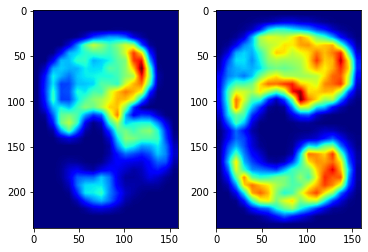

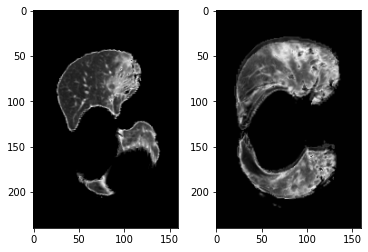


 68%|██████▊   | 70/103 [12:49<06:01, 10.96s/it]

LOSS MEDIO 0.6019732339041574
tensor([[0.2624, 0.7376],
        [0.1785, 0.8215],
        [0.6236, 0.3764],
        [0.5340, 0.4660]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2002027670', '2002029433', '2009015698', '2000018228']
tensor([1, 1, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 70, Loss: 0.552701, Accuracy: 75.000000
Total accuracy: 71.47887323943662


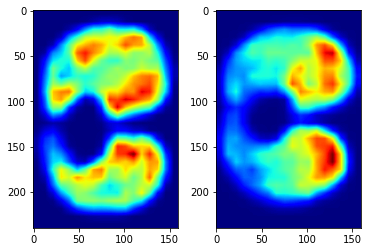

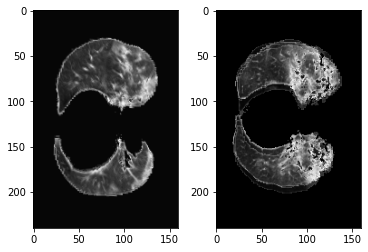


 69%|██████▉   | 71/103 [13:00<05:48, 10.89s/it]

LOSS MEDIO 0.601279252012011
tensor([[0.0484, 0.9516],
        [0.9496, 0.0504],
        [0.1811, 0.8189],
        [0.5397, 0.4603]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2000009272', '2002013985', '3013043756', '99041056']
tensor([1, 0, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 71, Loss: 0.440023, Accuracy: 100.000000
Total accuracy: 71.875


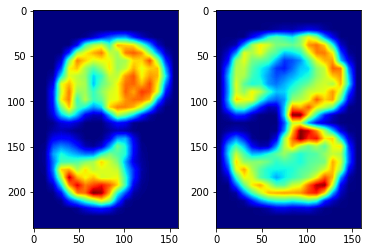

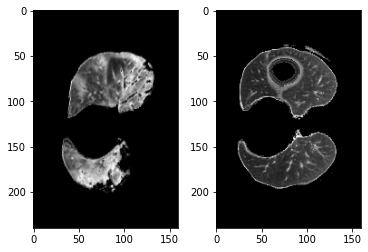


 70%|██████▉   | 72/103 [13:06<04:48,  9.30s/it]

LOSS MEDIO 0.5990395798451371
tensor([[0.5541, 0.4459],
        [0.0954, 0.9046],
        [0.8414, 0.1586],
        [0.3733, 0.6267]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2008023271', '2008024371', '2000006283', '2003012649']
tensor([0, 1, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 72, Loss: 0.498043, Accuracy: 100.000000
Total accuracy: 72.26027397260275


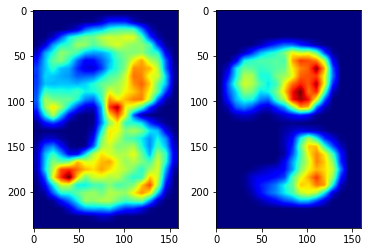

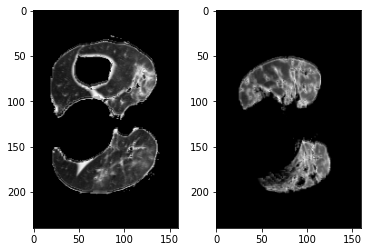


 71%|███████   | 73/103 [13:16<04:50,  9.68s/it]

LOSS MEDIO 0.5976560671035558
tensor([[0.2094, 0.7906],
        [0.0549, 0.9451],
        [0.7270, 0.2730],
        [0.9277, 0.0723]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2008024371', '2002034282', '2003012649', '2004015468']
tensor([1, 1, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 73, Loss: 0.522035, Accuracy: 75.000000
Total accuracy: 72.29729729729729


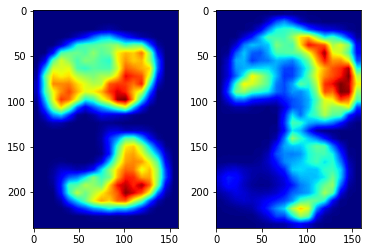

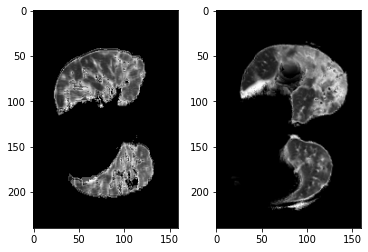


 72%|███████▏  | 74/103 [13:22<04:04,  8.42s/it]

LOSS MEDIO 0.5966341672716914
tensor([[0.7464, 0.2536],
        [0.1865, 0.8135],
        [0.1051, 0.8949],
        [0.7308, 0.2692]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013046656', '99018871', '3013030057', '99050758']
tensor([0, 1, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 74, Loss: 0.441952, Accuracy: 100.000000
Total accuracy: 72.66666666666667


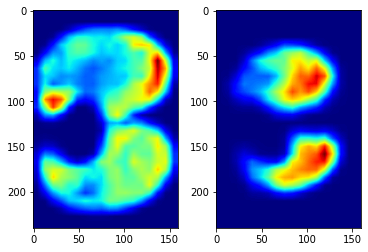

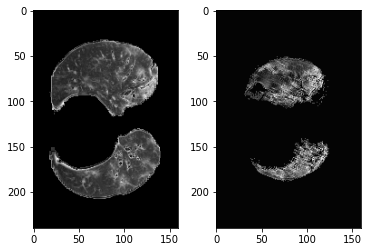


 73%|███████▎  | 75/103 [13:27<03:31,  7.56s/it]

LOSS MEDIO 0.5945717374483744
tensor([[0.0895, 0.9105],
        [0.6519, 0.3481],
        [0.8913, 0.1087],
        [0.5813, 0.4187]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2000042251', '2002027670', '2007003077', '3000337851']
tensor([0, 1, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 75, Loss: 0.758464, Accuracy: 50.000000
Total accuracy: 72.36842105263158


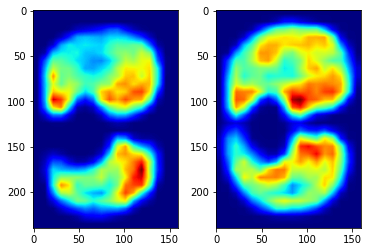

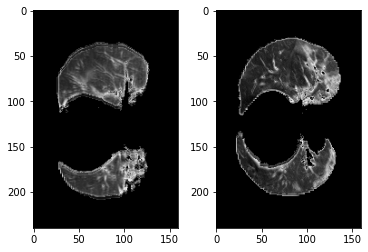


 74%|███████▍  | 76/103 [13:33<03:05,  6.87s/it]

LOSS MEDIO 0.5967282174449218
tensor([[0.5092, 0.4908],
        [0.7568, 0.2432],
        [0.8671, 0.1329],
        [0.1185, 0.8815]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2002027670', '3013052057', '99039473', '3013050174']
tensor([1, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 76, Loss: 0.486521, Accuracy: 75.000000
Total accuracy: 72.40259740259741


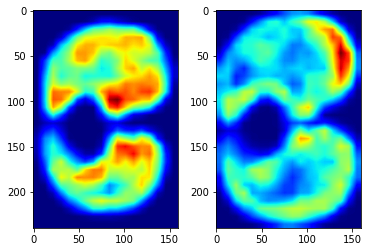

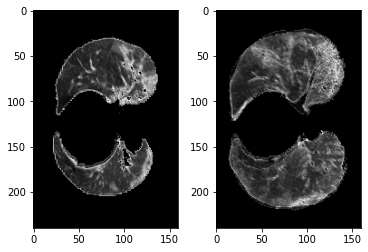


 75%|███████▍  | 77/103 [13:43<03:26,  7.94s/it]

LOSS MEDIO 0.5952969503093075
tensor([[0.5451, 0.4549],
        [0.6979, 0.3021],
        [0.7531, 0.2469],
        [0.0537, 0.9463]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2005035916', '2011012765', '2005016262', '3013051158']
tensor([0, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 77, Loss: 0.494703, Accuracy: 100.000000
Total accuracy: 72.75641025641026


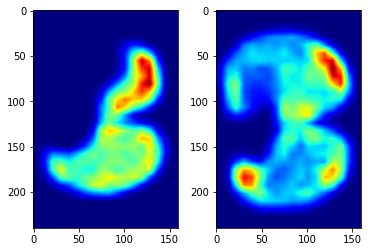

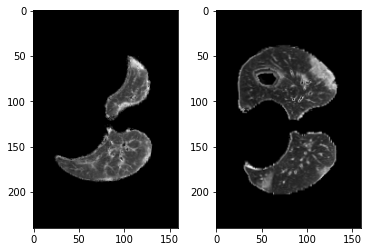


 76%|███████▌  | 78/103 [13:59<04:19, 10.37s/it]

LOSS MEDIO 0.5940072861237403
tensor([[0.1921, 0.8079],
        [0.9154, 0.0846],
        [0.5145, 0.4855],
        [0.3994, 0.6006]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2006004951', '3000332556', '2003022562', '2006021346']
tensor([1, 0, 0, 1], device='cuda:0')
Train - Epoch 27, Batch: 78, Loss: 0.517469, Accuracy: 100.000000
Total accuracy: 73.10126582278481


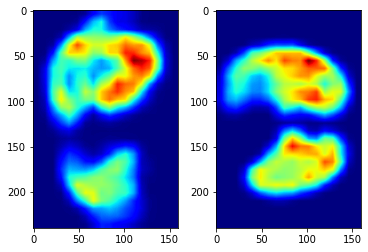

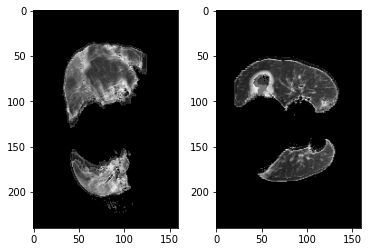


 77%|███████▋  | 79/103 [14:04<03:30,  8.79s/it]

LOSS MEDIO 0.5930384476728077
tensor([[0.4907, 0.5093],
        [0.4549, 0.5451],
        [0.6896, 0.3104],
        [0.3134, 0.6866]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2007021444', '2002047338', '97002989', '99005004']
tensor([1, 1, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 79, Loss: 0.782669, Accuracy: 50.000000
Total accuracy: 72.8125


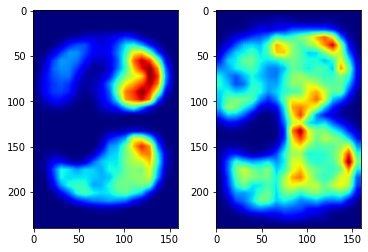

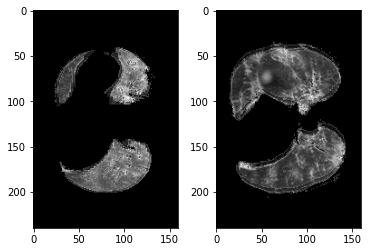


 78%|███████▊  | 80/103 [14:09<02:56,  7.68s/it]

LOSS MEDIO 0.5954088319092989
tensor([[0.8217, 0.1783],
        [0.3872, 0.6128],
        [0.1539, 0.8461],
        [0.5444, 0.4556]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3000663179', '2008005122', '3013050360', '2005009495']
tensor([0, 0, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 80, Loss: 0.745602, Accuracy: 50.000000
Total accuracy: 72.53086419753086


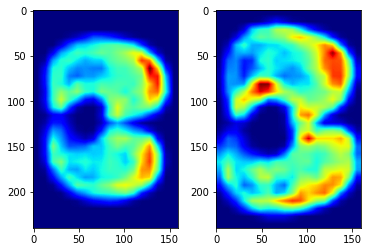

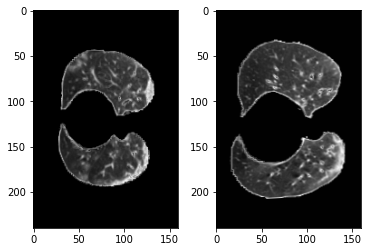


 79%|███████▊  | 81/103 [14:25<03:44, 10.23s/it]

LOSS MEDIO 0.5972630628097204
tensor([[0.4260, 0.5740],
        [0.0675, 0.9325],
        [0.8236, 0.1764],
        [0.7505, 0.2495]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['3013096757', '3013056260', '2003036294', '98026995']
tensor([0, 0, 0, 0], device='cuda:0')
Train - Epoch 27, Batch: 81, Loss: 0.720225, Accuracy: 50.000000
Total accuracy: 72.2560975609756


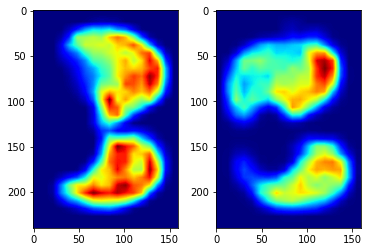

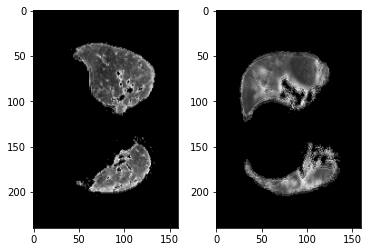


 80%|███████▉  | 82/103 [14:36<03:36, 10.29s/it]

LOSS MEDIO 0.5987625932548104
tensor([[0.2433, 0.7567],
        [0.0894, 0.9106],
        [0.6299, 0.3701],
        [0.8876, 0.1124]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['2011015370', '2000007568', '3013051159', '3008882257']
tensor([1, 1, 1, 1], device='cuda:0')
Train - Epoch 27, Batch: 82, Loss: 0.704769, Accuracy: 50.000000
Total accuracy: 71.98795180722891


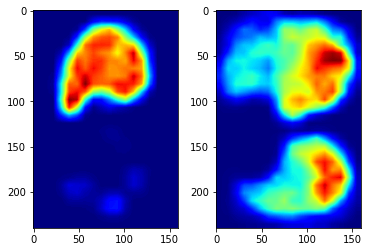

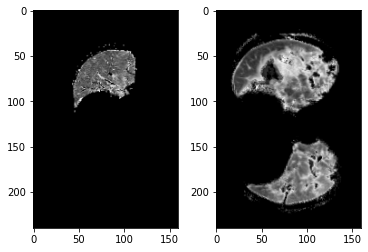


 81%|████████  | 83/103 [14:52<03:59, 11.99s/it]

LOSS MEDIO 0.6000397819352438
tensor([[0.2611, 0.7389],
        [0.7787, 0.2213],
        [0.0672, 0.9328],
        [0.7456, 0.2544]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['98004861', '98002419', '3013036660', '3013046656']
tensor([1, 0, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 83, Loss: 0.440995, Accuracy: 100.000000
Total accuracy: 72.32142857142857


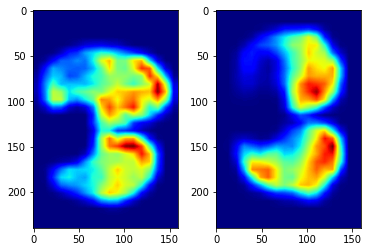

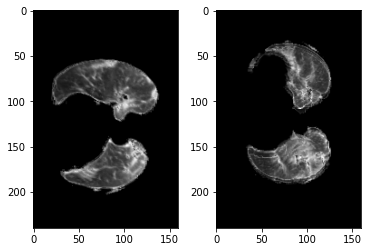


 82%|████████▏ | 84/103 [15:03<03:43, 11.74s/it]

LOSS MEDIO 0.5981463907020432
tensor([[0.3289, 0.6711],
        [0.3250, 0.6750],
        [0.0842, 0.9158],
        [0.9208, 0.0792]], device='cuda:0', grad_fn=<SoftmaxBackward>)
['97005904', '3003493356', '2005016576', '97005627']
tensor([1, 0, 1, 0], device='cuda:0')
Train - Epoch 27, Batch: 84, Loss: 0.534937, Accuracy: 75.000000
Total accuracy: 72.3529411764706


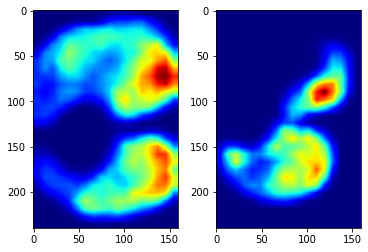

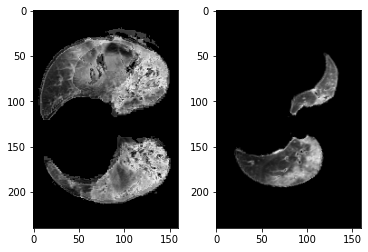


 83%|████████▎ | 85/103 [15:08<02:56,  9.81s/it]

LOSS MEDIO 0.5974027503939235


SystemError: ignored

In [ ]:
train()

In [ ]:
from sklearn import metrics

In [ ]:
acc_tutta = []
auc_tutta = []
loss_media = []
acc_tutta = []
for i in range(30, 40):
  model = torch.load( '/content/drive/My Drive/ADNI/model_medie_{}_decima_presa.pth'.format(str(i)))
  cfg = { 'n_epochs' : 10,
          'lr'       : 1e-4,
          'optimizer': optim.SGD}
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])
  
  acc_tot = []
  loss_tot = []

  for j in range(0, 1):
      #para_loader = pl.ParallelLoader(train_loader, [dev])

      print("Validation del modello")
      model.eval()  # Set 4odel to training mode
      
      loss_list, batch_list = [], []
      total_acc = []
      output_bc = []
      label_bc = []
      total_loss = 0
      count = 0
          
      for batch_idx, batch in enumerate(tqdm(validation_loader)):

          if batch_idx < len(validation_loader):
              
            total = 0
            correct = 0
                
            inputs = batch['Lung'][DATA].to(dev)
            label = batch['label'].to(dev, dtype=torch.long)

            output = model(inputs)
            loss = criterion(output, label)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == label).sum().item()

            
            output_bc.append(output.data.cpu().numpy()[:,1])
            label_bc.append(label.cpu().numpy())
            total_acc.append(correct/4*100)

            print('Train - Epoch %d, Batch: %d, Loss: %f, Accuracy: %f' % (i, batch_idx,  loss.detach().cpu().item(), correct/4*100))     
            print('Total accuracy: {}'.format(np.mean(total_acc)))
            loss_list.append(loss.detach().cpu().item())
            

      
      fpr, tpr, thresholds = metrics.roc_curve(np.concatenate(label_bc).ravel(), np.concatenate(output_bc).ravel())
      print(metrics.auc(fpr, tpr))
      acc_tutta.append(np.mean(total_acc))
      loss_media.append(np.mean(loss_list))
      auc_tutta.append(np.mean(auc))



    




















  0%|          | 0/9 [00:00<?, ?it/s]

Validation del modello


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



















 11%|█         | 1/9 [00:01<00:09,  1.19s/it]

Train - Epoch 30, Batch: 0, Loss: 0.669320, Accuracy: 50.000000
Total accuracy: 50.0





















 22%|██▏       | 2/9 [00:02<00:08,  1.18s/it]

Train - Epoch 30, Batch: 1, Loss: 0.554364, Accuracy: 100.000000
Total accuracy: 75.0





















 33%|███▎      | 3/9 [00:03<00:06,  1.16s/it]

Train - Epoch 30, Batch: 2, Loss: 0.689781, Accuracy: 75.000000
Total accuracy: 75.0





















 44%|████▍     | 4/9 [00:04<00:05,  1.16s/it]

Train - Epoch 30, Batch: 3, Loss: 0.672361, Accuracy: 50.000000
Total accuracy: 68.75





















 56%|█████▌    | 5/9 [00:05<00:04,  1.15s/it]

Train - Epoch 30, Batch: 4, Loss: 0.709936, Accuracy: 50.000000
Total accuracy: 65.0





















 67%|██████▋   | 6/9 [00:06<00:03,  1.14s/it]

Train - Epoch 30, Batch: 5, Loss: 0.440902, Accuracy: 100.000000
Total accuracy: 70.83333333333333





















 78%|███████▊  | 7/9 [00:07<00:02,  1.14s/it]

Train - Epoch 30, Batch: 6, Loss: 0.605121, Accuracy: 75.000000
Total accuracy: 71.42857142857143





















 89%|████████▉ | 8/9 [00:09<00:01,  1.15s/it]

Train - Epoch 30, Batch: 7, Loss: 0.448847, Accuracy: 100.000000
Total accuracy: 75.0





















100%|██████████| 9/9 [00:10<00:00,  1.14s/it]



















  0%|          | 0/9 [00:00<?, ?it/s]

Train - Epoch 30, Batch: 8, Loss: 0.568633, Accuracy: 75.000000
Total accuracy: 75.0
0.7534722222222222
Validation del modello





















 11%|█         | 1/9 [00:01<00:09,  1.13s/it]

Train - Epoch 31, Batch: 0, Loss: 0.700684, Accuracy: 50.000000
Total accuracy: 50.0





















 22%|██▏       | 2/9 [00:02<00:07,  1.13s/it]

Train - Epoch 31, Batch: 1, Loss: 0.622663, Accuracy: 75.000000
Total accuracy: 62.5





















 33%|███▎      | 3/9 [00:03<00:06,  1.14s/it]

Train - Epoch 31, Batch: 2, Loss: 0.578373, Accuracy: 50.000000
Total accuracy: 58.333333333333336





















 44%|████▍     | 4/9 [00:04<00:05,  1.14s/it]

Train - Epoch 31, Batch: 3, Loss: 0.528710, Accuracy: 100.000000
Total accuracy: 68.75





















 56%|█████▌    | 5/9 [00:05<00:04,  1.14s/it]

Train - Epoch 31, Batch: 4, Loss: 0.657628, Accuracy: 75.000000
Total accuracy: 70.0





















 67%|██████▋   | 6/9 [00:06<00:03,  1.14s/it]

Train - Epoch 31, Batch: 5, Loss: 0.633440, Accuracy: 75.000000
Total accuracy: 70.83333333333333





















 78%|███████▊  | 7/9 [00:07<00:02,  1.14s/it]

Train - Epoch 31, Batch: 6, Loss: 0.644641, Accuracy: 50.000000
Total accuracy: 67.85714285714286





















 89%|████████▉ | 8/9 [00:09<00:01,  1.15s/it]

Train - Epoch 31, Batch: 7, Loss: 0.538521, Accuracy: 75.000000
Total accuracy: 68.75





















100%|██████████| 9/9 [00:10<00:00,  1.15s/it]



















  0%|          | 0/9 [00:00<?, ?it/s]

Train - Epoch 31, Batch: 8, Loss: 0.483518, Accuracy: 100.000000
Total accuracy: 72.22222222222223
0.7454545454545455
Validation del modello





















 11%|█         | 1/9 [00:01<00:08,  1.11s/it]

Train - Epoch 32, Batch: 0, Loss: 0.430796, Accuracy: 100.000000
Total accuracy: 100.0





















 22%|██▏       | 2/9 [00:02<00:07,  1.11s/it]

Train - Epoch 32, Batch: 1, Loss: 0.635977, Accuracy: 75.000000
Total accuracy: 87.5





















 33%|███▎      | 3/9 [00:03<00:06,  1.12s/it]

Train - Epoch 32, Batch: 2, Loss: 0.480510, Accuracy: 100.000000
Total accuracy: 91.66666666666667





















 44%|████▍     | 4/9 [00:04<00:05,  1.14s/it]

Train - Epoch 32, Batch: 3, Loss: 0.519528, Accuracy: 100.000000
Total accuracy: 93.75





















 56%|█████▌    | 5/9 [00:05<00:04,  1.15s/it]

Train - Epoch 32, Batch: 4, Loss: 0.673170, Accuracy: 75.000000
Total accuracy: 90.0





















 67%|██████▋   | 6/9 [00:06<00:03,  1.15s/it]

Train - Epoch 32, Batch: 5, Loss: 0.605298, Accuracy: 75.000000
Total accuracy: 87.5





















 78%|███████▊  | 7/9 [00:08<00:02,  1.15s/it]

Train - Epoch 32, Batch: 6, Loss: 0.813619, Accuracy: 25.000000
Total accuracy: 78.57142857142857





















 89%|████████▉ | 8/9 [00:09<00:01,  1.15s/it]

Train - Epoch 32, Batch: 7, Loss: 0.443457, Accuracy: 100.000000
Total accuracy: 81.25





















100%|██████████| 9/9 [00:10<00:00,  1.15s/it]

Train - Epoch 32, Batch: 8, Loss: 0.708451, Accuracy: 50.000000
Total accuracy: 77.77777777777777
0.738181818181818






















  0%|          | 0/9 [00:00<?, ?it/s]

Validation del modello





















 11%|█         | 1/9 [00:01<00:09,  1.17s/it]

Train - Epoch 33, Batch: 0, Loss: 0.470160, Accuracy: 100.000000
Total accuracy: 100.0





















 22%|██▏       | 2/9 [00:02<00:08,  1.16s/it]

Train - Epoch 33, Batch: 1, Loss: 0.680965, Accuracy: 50.000000
Total accuracy: 75.0





















 33%|███▎      | 3/9 [00:03<00:06,  1.16s/it]

Train - Epoch 33, Batch: 2, Loss: 0.571461, Accuracy: 75.000000
Total accuracy: 75.0





















 44%|████▍     | 4/9 [00:04<00:05,  1.16s/it]

Train - Epoch 33, Batch: 3, Loss: 0.739934, Accuracy: 25.000000
Total accuracy: 62.5





















 56%|█████▌    | 5/9 [00:05<00:04,  1.17s/it]

Train - Epoch 33, Batch: 4, Loss: 0.756188, Accuracy: 50.000000
Total accuracy: 60.0





















 67%|██████▋   | 6/9 [00:06<00:03,  1.16s/it]

Train - Epoch 33, Batch: 5, Loss: 0.621253, Accuracy: 75.000000
Total accuracy: 62.5





















 78%|███████▊  | 7/9 [00:08<00:02,  1.16s/it]

Train - Epoch 33, Batch: 6, Loss: 0.508224, Accuracy: 75.000000
Total accuracy: 64.28571428571429





















 89%|████████▉ | 8/9 [00:09<00:01,  1.15s/it]

Train - Epoch 33, Batch: 7, Loss: 0.565549, Accuracy: 50.000000
Total accuracy: 62.5





















100%|██████████| 9/9 [00:10<00:00,  1.16s/it]

Train - Epoch 33, Batch: 8, Loss: 0.609754, Accuracy: 75.000000
Total accuracy: 63.888888888888886
0.7454545454545454






















  0%|          | 0/9 [00:00<?, ?it/s]

Validation del modello





















 11%|█         | 1/9 [00:01<00:09,  1.13s/it]

Train - Epoch 34, Batch: 0, Loss: 0.504109, Accuracy: 75.000000
Total accuracy: 75.0





















 22%|██▏       | 2/9 [00:02<00:07,  1.14s/it]

Train - Epoch 34, Batch: 1, Loss: 0.633428, Accuracy: 75.000000
Total accuracy: 75.0





















 33%|███▎      | 3/9 [00:03<00:06,  1.15s/it]

Train - Epoch 34, Batch: 2, Loss: 0.527313, Accuracy: 75.000000
Total accuracy: 75.0





















 44%|████▍     | 4/9 [00:04<00:05,  1.15s/it]

Train - Epoch 34, Batch: 3, Loss: 0.585722, Accuracy: 75.000000
Total accuracy: 75.0





















 56%|█████▌    | 5/9 [00:05<00:04,  1.15s/it]

Train - Epoch 34, Batch: 4, Loss: 0.636655, Accuracy: 75.000000
Total accuracy: 75.0





















 67%|██████▋   | 6/9 [00:06<00:03,  1.15s/it]

Train - Epoch 34, Batch: 5, Loss: 0.725453, Accuracy: 50.000000
Total accuracy: 70.83333333333333





















 78%|███████▊  | 7/9 [00:08<00:02,  1.14s/it]

Train - Epoch 34, Batch: 6, Loss: 0.531900, Accuracy: 100.000000
Total accuracy: 75.0





















 89%|████████▉ | 8/9 [00:09<00:01,  1.15s/it]

Train - Epoch 34, Batch: 7, Loss: 0.645134, Accuracy: 50.000000
Total accuracy: 71.875





















100%|██████████| 9/9 [00:10<00:00,  1.15s/it]

Train - Epoch 34, Batch: 8, Loss: 0.588773, Accuracy: 100.000000
Total accuracy: 75.0
0.72






















  0%|          | 0/9 [00:00<?, ?it/s]

Validation del modello





















 11%|█         | 1/9 [00:01<00:09,  1.17s/it]

Train - Epoch 35, Batch: 0, Loss: 0.526377, Accuracy: 75.000000
Total accuracy: 75.0





















 22%|██▏       | 2/9 [00:02<00:08,  1.16s/it]

Train - Epoch 35, Batch: 1, Loss: 0.649222, Accuracy: 75.000000
Total accuracy: 75.0





















 33%|███▎      | 3/9 [00:03<00:06,  1.16s/it]

Train - Epoch 35, Batch: 2, Loss: 0.834545, Accuracy: 25.000000
Total accuracy: 58.333333333333336





















 44%|████▍     | 4/9 [00:04<00:05,  1.15s/it]

Train - Epoch 35, Batch: 3, Loss: 0.506738, Accuracy: 100.000000
Total accuracy: 68.75





















 56%|█████▌    | 5/9 [00:05<00:04,  1.16s/it]

Train - Epoch 35, Batch: 4, Loss: 0.413271, Accuracy: 100.000000
Total accuracy: 75.0





















 67%|██████▋   | 6/9 [00:06<00:03,  1.15s/it]

Train - Epoch 35, Batch: 5, Loss: 0.525881, Accuracy: 100.000000
Total accuracy: 79.16666666666667





















 78%|███████▊  | 7/9 [00:08<00:02,  1.15s/it]

Train - Epoch 35, Batch: 6, Loss: 0.779050, Accuracy: 25.000000
Total accuracy: 71.42857142857143





















 89%|████████▉ | 8/9 [00:09<00:01,  1.14s/it]

Train - Epoch 35, Batch: 7, Loss: 0.517888, Accuracy: 75.000000
Total accuracy: 71.875





















100%|██████████| 9/9 [00:10<00:00,  1.15s/it]

Train - Epoch 35, Batch: 8, Loss: 0.602763, Accuracy: 75.000000
Total accuracy: 72.22222222222223
0.6945454545454546






















  0%|          | 0/9 [00:00<?, ?it/s]

Validation del modello





















 11%|█         | 1/9 [00:01<00:09,  1.14s/it]

Train - Epoch 36, Batch: 0, Loss: 0.481805, Accuracy: 100.000000
Total accuracy: 100.0





















 22%|██▏       | 2/9 [00:02<00:08,  1.14s/it]

Train - Epoch 36, Batch: 1, Loss: 0.610738, Accuracy: 50.000000
Total accuracy: 75.0





















 33%|███▎      | 3/9 [00:03<00:06,  1.14s/it]

Train - Epoch 36, Batch: 2, Loss: 0.627624, Accuracy: 75.000000
Total accuracy: 75.0





















 44%|████▍     | 4/9 [00:04<00:05,  1.15s/it]

Train - Epoch 36, Batch: 3, Loss: 0.671818, Accuracy: 75.000000
Total accuracy: 75.0





















 56%|█████▌    | 5/9 [00:05<00:04,  1.14s/it]

Train - Epoch 36, Batch: 4, Loss: 0.566642, Accuracy: 75.000000
Total accuracy: 75.0





















 67%|██████▋   | 6/9 [00:06<00:03,  1.14s/it]

Train - Epoch 36, Batch: 5, Loss: 0.883503, Accuracy: 0.000000
Total accuracy: 62.5





















 78%|███████▊  | 7/9 [00:07<00:02,  1.14s/it]

Train - Epoch 36, Batch: 6, Loss: 0.438158, Accuracy: 100.000000
Total accuracy: 67.85714285714286





















 89%|████████▉ | 8/9 [00:09<00:01,  1.15s/it]

Train - Epoch 36, Batch: 7, Loss: 0.624904, Accuracy: 75.000000
Total accuracy: 68.75





















100%|██████████| 9/9 [00:10<00:00,  1.14s/it]

Train - Epoch 36, Batch: 8, Loss: 0.488558, Accuracy: 100.000000
Total accuracy: 72.22222222222223
0.7465277777777777






















  0%|          | 0/9 [00:00<?, ?it/s]

Validation del modello





















 11%|█         | 1/9 [00:01<00:09,  1.14s/it]

Train - Epoch 37, Batch: 0, Loss: 0.700672, Accuracy: 50.000000
Total accuracy: 50.0





















 22%|██▏       | 2/9 [00:02<00:08,  1.15s/it]

Train - Epoch 37, Batch: 1, Loss: 0.493580, Accuracy: 100.000000
Total accuracy: 75.0





















 33%|███▎      | 3/9 [00:03<00:07,  1.17s/it]

Train - Epoch 37, Batch: 2, Loss: 0.577073, Accuracy: 75.000000
Total accuracy: 75.0





















 44%|████▍     | 4/9 [00:04<00:05,  1.18s/it]

Train - Epoch 37, Batch: 3, Loss: 0.583472, Accuracy: 50.000000
Total accuracy: 68.75





















 56%|█████▌    | 5/9 [00:05<00:04,  1.18s/it]

Train - Epoch 37, Batch: 4, Loss: 0.564013, Accuracy: 100.000000
Total accuracy: 75.0





















 67%|██████▋   | 6/9 [00:07<00:03,  1.17s/it]

Train - Epoch 37, Batch: 5, Loss: 0.728587, Accuracy: 50.000000
Total accuracy: 70.83333333333333





















 78%|███████▊  | 7/9 [00:08<00:02,  1.17s/it]

Train - Epoch 37, Batch: 6, Loss: 0.517952, Accuracy: 100.000000
Total accuracy: 75.0





















 89%|████████▉ | 8/9 [00:09<00:01,  1.16s/it]

Train - Epoch 37, Batch: 7, Loss: 0.692548, Accuracy: 50.000000
Total accuracy: 71.875





















100%|██████████| 9/9 [00:10<00:00,  1.17s/it]

Train - Epoch 37, Batch: 8, Loss: 0.589022, Accuracy: 75.000000
Total accuracy: 72.22222222222223
0.7118055555555556






















  0%|          | 0/9 [00:00<?, ?it/s]

Validation del modello





















 11%|█         | 1/9 [00:01<00:09,  1.16s/it]

Train - Epoch 38, Batch: 0, Loss: 0.770469, Accuracy: 25.000000
Total accuracy: 25.0





















 22%|██▏       | 2/9 [00:02<00:08,  1.16s/it]

Train - Epoch 38, Batch: 1, Loss: 0.633143, Accuracy: 75.000000
Total accuracy: 50.0





















 33%|███▎      | 3/9 [00:03<00:06,  1.15s/it]

Train - Epoch 38, Batch: 2, Loss: 0.693267, Accuracy: 75.000000
Total accuracy: 58.333333333333336





















 44%|████▍     | 4/9 [00:04<00:05,  1.16s/it]

Train - Epoch 38, Batch: 3, Loss: 0.620563, Accuracy: 75.000000
Total accuracy: 62.5





















 56%|█████▌    | 5/9 [00:05<00:04,  1.16s/it]

Train - Epoch 38, Batch: 4, Loss: 0.534279, Accuracy: 75.000000
Total accuracy: 65.0





















 67%|██████▋   | 6/9 [00:06<00:03,  1.16s/it]

Train - Epoch 38, Batch: 5, Loss: 0.527885, Accuracy: 100.000000
Total accuracy: 70.83333333333333





















 78%|███████▊  | 7/9 [00:08<00:02,  1.15s/it]

Train - Epoch 38, Batch: 6, Loss: 0.636257, Accuracy: 50.000000
Total accuracy: 67.85714285714286





















 89%|████████▉ | 8/9 [00:09<00:01,  1.15s/it]

Train - Epoch 38, Batch: 7, Loss: 0.580831, Accuracy: 75.000000
Total accuracy: 68.75





















100%|██████████| 9/9 [00:10<00:00,  1.15s/it]

Train - Epoch 38, Batch: 8, Loss: 0.627492, Accuracy: 75.000000
Total accuracy: 69.44444444444444
0.7018181818181818






















  0%|          | 0/9 [00:00<?, ?it/s]

Validation del modello





















 11%|█         | 1/9 [00:01<00:09,  1.13s/it]

Train - Epoch 39, Batch: 0, Loss: 0.686066, Accuracy: 50.000000
Total accuracy: 50.0





















 22%|██▏       | 2/9 [00:02<00:07,  1.14s/it]

Train - Epoch 39, Batch: 1, Loss: 0.601229, Accuracy: 75.000000
Total accuracy: 62.5





















 33%|███▎      | 3/9 [00:03<00:06,  1.14s/it]

Train - Epoch 39, Batch: 2, Loss: 0.542426, Accuracy: 75.000000
Total accuracy: 66.66666666666667





















 44%|████▍     | 4/9 [00:04<00:05,  1.14s/it]

Train - Epoch 39, Batch: 3, Loss: 0.784120, Accuracy: 50.000000
Total accuracy: 62.5





















 56%|█████▌    | 5/9 [00:05<00:04,  1.15s/it]

Train - Epoch 39, Batch: 4, Loss: 0.529252, Accuracy: 75.000000
Total accuracy: 65.0





















 67%|██████▋   | 6/9 [00:06<00:03,  1.14s/it]

Train - Epoch 39, Batch: 5, Loss: 0.720079, Accuracy: 25.000000
Total accuracy: 58.333333333333336





















 78%|███████▊  | 7/9 [00:08<00:02,  1.15s/it]

Train - Epoch 39, Batch: 6, Loss: 0.442399, Accuracy: 100.000000
Total accuracy: 64.28571428571429





















 89%|████████▉ | 8/9 [00:09<00:01,  1.15s/it]

Train - Epoch 39, Batch: 7, Loss: 0.674062, Accuracy: 50.000000
Total accuracy: 62.5





















100%|██████████| 9/9 [00:10<00:00,  1.15s/it]

Train - Epoch 39, Batch: 8, Loss: 0.622329, Accuracy: 75.000000
Total accuracy: 63.888888888888886
0.6872727272727273


In [ ]:
metrics.auc(fpr, tpr)

nan

In [ ]:
gradients = model.encoder.get_activations_gradient()

In [ ]:
gradients.shape

In [ ]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[2, 3, 4])[0]

# get the activations of the last convolutional layer
activations = model.encoder.get_activations(img.to(dev)).detach()
print(activations.shape)
# weight the channels by corresponding gradients
for i in range(40):
    activations[:, i, :, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap.cpu(), 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)
print(heatmap.shape)
# draw the heatmap
print(heatmap[0][:, :, :])
plt.imshow(heatmap[0][:, :, 20])



In [ ]:
import cv2

heatmap2 = cv2.resize(np.float32(heatmap[0][:, :, 20]), (160, 240))
heatmap2 = np.uint8(-255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
print(heatmap2[0])

plt.imshow(heatmap2)

In [ ]:
plt.imshow(backtorgb, cmap = 'gray')

In [ ]:
img_2

In [ ]:
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[2]):
    plt.subplot(5, 4, i+1) 
    plt.imshow(filter[0][0, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
params = list(Net().parameters())
weight = np.squeeze(params[-11].data.numpy())

In [ ]:
weight.shape